## Porter – Delivery Time Estimation Project

**Porter** is India's Largest Marketplace for Intra-City Logistics.  
A leader in the country's **$40 billion intra-city logistics market**, Porter strives to improve the lives of **1,50,000+ driver-partners** by providing them with consistent earnings and independence.  
Currently, the company has serviced **5+ million customers**.

---

### 🍴 Business Context

Porter collaborates with a wide range of restaurants to deliver their items directly to customers.  
With multiple delivery partners available, Porter aims to **estimate the delivery time** more accurately based on factors such as:

- What customers are ordering  
- The restaurant location  
- Availability and activity of delivery partners  

This dataset provides the required information to train a **regression model** that predicts the estimated delivery time based on all relevant features.

---

### Dataset: Porter Data

Each row in the dataset represents a **unique delivery**.  
Each column describes a feature as detailed below:

| Feature | Description |
|----------|--------------|
| `market_id` | Integer ID representing the market where the restaurant is located |
| `created_at` | Timestamp of when the order was placed |
| `actual_delivery_time` | Timestamp of when the order was delivered |
| `store_primary_category` | Category/type of restaurant |
| `order_protocol` | Integer code for how the order was placed (e.g., through Porter app, phone call, pre-booking, third-party, etc.) |
| `total_items` | Total number of items in the order |
| `subtotal` | Final price of the order |
| `num_distinct_items` | Number of distinct items in the order |
| `min_item_price` | Price of the cheapest item in the order |
| `max_item_price` | Price of the most expensive item in the order |
| `total_onshift_partners` | Number of delivery partners on duty when the order was placed |
| `total_busy_partners` | Number of delivery partners currently engaged in other deliveries |
| `total_outstanding_orders` | Total number of active orders yet to be fulfilled |
| `estimated_store_to_consumer_driving_duration` | Estimated travel time from restaurant to customer |

---

### Objective

Build a **regression model** to accurately predict the **delivery time** for a given order using operational and order-level features.

---


In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00


In [2]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats as stats
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

from scipy.stats import f_oneway, chi2_contingency
from scipy.stats import pearsonr, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

from sklearn.neighbors import LocalOutlierFactor

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import plotly.express as px
import joblib
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, confusion_matrix, roc_auc_score,
    roc_curve
)
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers


#import tensorflow_addons as tfa

import textwrap

In [4]:
!gdown 1KEZiKA3HZp37Nr27VJFkzPFtIW0YmcTF
df = pd.read_csv("/content/data_2.csv")

Downloading...
From: https://drive.google.com/uc?id=1KEZiKA3HZp37Nr27VJFkzPFtIW0YmcTF
To: /content/data_2.csv
100% 15.7M/15.7M [00:00<00:00, 41.1MB/s]


In [5]:
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 6.0                      18.0   
3                 6.0                       8.0   
4                 5.0                       7.0   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         289.0  
3                                         795.0  
4                                         205.0

In [6]:
print(f"\n{'='*40}\nDATASET SUMMARY\n{'='*40}")
print(f"Shape : {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Duplicate Rows : {df.duplicated().sum()}")

print(f"\n{'-'*40}\nUNIQUE VALUE COUNT PER FEATURE\n{'-'*40}")
print(df.nunique().sort_values(ascending=False))

print(f"\n{'-'*40}\nDESCRIPTIVE STATISTICS\n{'-'*40}")
print(df.describe().transpose())


DATASET SUMMARY
Shape : 175777 rows x 14 columns
Duplicate Rows : 0

----------------------------------------
UNIQUE VALUE COUNT PER FEATURE
----------------------------------------
created_at                                      162649
actual_delivery_time                            160344
subtotal                                          8182
max_item_price                                    2585
min_item_price                                    2251
estimated_store_to_consumer_driving_duration      1318
total_outstanding_orders                           281
total_onshift_dashers                              172
total_busy_dashers                                 158
store_primary_category                              73
total_items                                         54
num_distinct_items                                  20
order_protocol                                       7
market_id                                            6
dtype: int64

---------------------------------

In [7]:
missing = df.isnull().sum()
missing_percent = (missing / len(df) * 100).round(2)
missing_summary = pd.DataFrame({'missing_count': missing, 'missing_%': missing_percent})
print(missing_summary[missing_summary['missing_count'] > 0].sort_values(by='missing_%', ascending=False))
print("-"*50)
print("Missing values per feature:")
print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))
print("Percentage of missing values:")
print((df.isnull().mean()*100)[df.isnull().sum()>0].sort_values(ascending=False).round(2))


Empty DataFrame
Columns: [missing_count, missing_%]
Index: []
--------------------------------------------------
Missing values per feature:
Series([], dtype: int64)
Percentage of missing values:
Series([], dtype: float64)


In [8]:
print(df.dtypes.value_counts())
print("-"*50,"\n")
print(df.dtypes)

float64    6
int64      6
object     2
Name: count, dtype: int64
-------------------------------------------------- 

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_primary_category                            int64
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_store_to_consumer_driving_duration    float64
dtype: object


In [9]:
for col in df.select_dtypes(include=['object', 'category']):
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts(dropna=False).head(5))



Value counts for 'created_at':
created_at
2015-02-11 19:50:43    6
2015-02-11 19:51:06    5
2015-02-08 02:20:03    5
2015-01-31 01:41:10    5
2015-01-24 01:56:33    5
Name: count, dtype: int64

Value counts for 'actual_delivery_time':
actual_delivery_time
2015-02-09 03:50:01    5
2015-02-16 03:06:54    5
2015-02-14 02:58:40    5
2015-02-15 03:44:45    5
2015-02-14 03:01:28    5
Name: count, dtype: int64


In [10]:
# Store original column names
old_cols = df.columns.copy()

# Replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')

# Find changed columns
changed_cols = [c for c, old in zip(df.columns, old_cols) if c != old]

print(f"Number of affected columns: {len(changed_cols)}")
print("Changed columns:")
print(changed_cols)

Number of affected columns: 0
Changed columns:
[]


In [11]:
# Converting time columns to datetime format
datetime_cols = ['created_at', 'actual_delivery_time']
for _ in datetime_cols:
    df[_] = pd.to_datetime(df[_], errors='coerce')
    print(f"🔄 Converted '{_}' to 'datetime'")

def convert_numeric_to_category(df, threshold=29):
    """
    Converts numeric columns to category dtype if they have low cardinality.

    Parameters:
    - df: pandas DataFrame
    - threshold: max number of unique values to consider as categorical (default = 10)

    Returns:
    - df: DataFrame with updated dtypes
    """
    for col in df.select_dtypes(include=['number', 'object']).columns:
        unique_vals = df[col].nunique()
        if unique_vals <= threshold:
            df[col] = df[col].astype('category')
            print(f"🔄 Converted '{col}' to 'category' (unique values = {unique_vals})")
    return df

# Converting the datatypes to category for columns like having uniques values less tha 29.
df = convert_numeric_to_category(df)

🔄 Converted 'created_at' to 'datetime'
🔄 Converted 'actual_delivery_time' to 'datetime'
🔄 Converted 'market_id' to 'category' (unique values = 6)
🔄 Converted 'order_protocol' to 'category' (unique values = 7)
🔄 Converted 'num_distinct_items' to 'category' (unique values = 20)


In [12]:
print(f"Duplicate Rows : {df.duplicated().sum()}")

Duplicate Rows : 0


In [13]:
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']) / pd.Timedelta(minutes=1)

df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek

df.drop(['created_at','actual_delivery_time'],axis=1,inplace=True)

In [14]:
print(f"Duplicate Rows : {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Duplicate Rows : {df.duplicated().sum()}")

Duplicate Rows : 15
Duplicate Rows : 0


In [15]:
df['store_primary_category'] = df['store_primary_category'].astype('category')
print(df['store_primary_category'].cat.categories)  # Index of unique categories
print(df['store_primary_category'].cat.codes)       # Integer codes for each row

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72],
      dtype='int64')
0          4
1         46
2         36
3         38
4         38
          ..
175772    28
175773    28
175774    28
175775    58
175776    58
Length: 175762, dtype: int8




> # Missing Data Treatment and Imputation



In [16]:
# Configure logger globally
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

class AutoMissingValueHandler:
    def __init__(self, method='simple', strategy='mean', non_num_strategy='most_frequent',
                 threshold=30, add_indicator=False):
        """
        Automatically handles missing values using selected imputation strategies.
        """
        self.method = method
        self.strategy = strategy
        self.non_num_strategy = non_num_strategy
        self.threshold = threshold
        self.add_indicator = add_indicator
        self.pipeline = None
        self.feature_names_ = None

        if not (0 <= self.threshold <= 100):
            raise ValueError(f"Threshold should be between 0 and 100, got {self.threshold}")

    def build_pipeline(self, X):
        """Build the preprocessing pipeline based on the selected method"""
        if X.empty:
            raise ValueError("Input DataFrame is empty.")

        numeric_columns = X.select_dtypes(include=[np.number]).columns
        non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns

        logger.info(f"Numeric columns: {numeric_columns.tolist()}")
        logger.info(f"Non-numeric columns: {non_numeric_columns.tolist()}")

        # Choose transformers
        if self.method == 'simple':
            numeric_transformer = SimpleImputer(strategy=self.strategy, add_indicator=self.add_indicator)
            non_numeric_transformer = SimpleImputer(strategy=self.non_num_strategy,
                                                    add_indicator=self.add_indicator)
        elif self.method == 'knn':
            numeric_transformer = KNNImputer(n_neighbors=5)
            non_numeric_transformer = SimpleImputer(strategy=self.non_num_strategy,
                                                    add_indicator=self.add_indicator)
        elif self.method == 'iterative':
            numeric_transformer = IterativeImputer(max_iter=10, random_state=0)
            non_numeric_transformer = SimpleImputer(strategy=self.non_num_strategy,
                                                    add_indicator=self.add_indicator)
        else:
            raise ValueError("Invalid method. Choose from ['simple', 'knn', 'iterative'].")

        self.pipeline = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_columns),
            ('non_num', non_numeric_transformer, non_numeric_columns)
        ]).set_output(transform="pandas")

    def fit(self, X):
        """Fit the imputation pipeline to the data"""
        logger.info("Fitting imputation model...")
        self.build_pipeline(X)
        self.pipeline.fit(X)
        self.feature_names_ = X.columns
        return self

    def transform(self, X):
        """Apply the transformation to new data"""
        if X.empty:
            raise ValueError("Input DataFrame is empty.")

        if not self.pipeline:
            raise ValueError("Pipeline is not fitted. Call `fit` first.")

        logger.info("Transforming data...")
        df_transformed = self.pipeline.transform(X)  # ✅ Now returns DataFrame directly
        df_transformed.columns = df_transformed.columns.str.replace(r'^(num|non_num)__', '', regex=True)
        return df_transformed


    def fit_transform(self, X):
        """Fit and transform in one step"""
        return self.fit(X).transform(X)

    def decide_strategy_based_on_missing(self, df):
        """Automatically decide method based on missing percentage threshold"""
        if df.empty:
            raise ValueError("Input DataFrame is empty.")

        missing_percentage = (df.isnull().sum() / len(df)) * 100
        high_missing_columns = missing_percentage[missing_percentage > self.threshold].index

        logger.info(f"Columns with missing > {self.threshold}%: {high_missing_columns.tolist()}")

        # Loop through each column and decide the method for imputation
        for column in high_missing_columns:
            if missing_percentage[column] > 50:
                # If missing data > 50%, use iterative imputation
                self.method = 'iterative'
                logger.info(f"Switching method to 'iterative' for column '{column}' with {missing_percentage[column]:.2f}% missing data.")
            elif missing_percentage[column] > self.threshold:
                # If missing data > threshold but < 50%, use KNN imputation
                self.method = 'knn'
                logger.info(f"Switching method to 'knn' for column '{column}' with {missing_percentage[column]:.2f}% missing data.")
            else:
                # Otherwise, use simple imputation (mean or most frequent)
                self.method = 'simple'
                logger.info(f"Using 'simple' imputation for column '{column}' with {missing_percentage[column]:.2f}% missing data.")

        # Rebuild the pipeline after deciding on the method
        self.build_pipeline(df)


    def plot_missing(self, df):
        """Plot missing value count for each column"""
        if df.empty:
            logger.warning("Skipping plot: DataFrame is empty.")
            return

        missing_counts = df.isna().sum()
        missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

        if missing_counts.empty:
            logger.info("No missing values to plot.")
            return

        if (missing_counts <= 0).any():
            logger.warning("Found zero or negative missing counts. Skipping log scale.")
            yscale = 'linear'
        else:
            yscale = 'log'

        plt.figure(figsize=(12, 6))
        sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="viridis", dodge=False)
        plt.yscale(yscale)
        plt.title("Missing Values per Column", fontsize=14)
        plt.xlabel("Columns", fontsize=12)
        plt.ylabel("Missing Count" + (" (log scale)" if yscale == 'log' else ""), fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def missing_data(self, df):
        """Return summary of missing data"""
        if df.empty:
            raise ValueError("Input DataFrame is empty.")

        total_missing = df.isnull().sum()
        percent_missing = (total_missing / len(df)) * 100
        summary = pd.concat([total_missing, percent_missing], axis=1)
        summary.columns = ['Total', 'Percent']
        return summary.sort_values(by='Total', ascending=False)

    def handle_missing_data(self, df):
        """End-to-end handling: decide strategy, fit, and transform"""
        logger.info("Handling missing data end-to-end.")
        self.decide_strategy_based_on_missing(df)
        return self.fit_transform(df)


In [17]:
handler = AutoMissingValueHandler(threshold=0)
print(handler.missing_data(df))

                                              Total  Percent
market_id                                         0      0.0
store_primary_category                            0      0.0
order_protocol                                    0      0.0
total_items                                       0      0.0
subtotal                                          0      0.0
num_distinct_items                                0      0.0
min_item_price                                    0      0.0
max_item_price                                    0      0.0
total_onshift_dashers                             0      0.0
total_busy_dashers                                0      0.0
total_outstanding_orders                          0      0.0
estimated_store_to_consumer_driving_duration      0      0.0
time_taken                                        0      0.0
order_hour                                        0      0.0
order_dayofweek                                   0      0.0


No Missing Value present in Dataset

In [18]:
df.head(5)

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                  4             557            1239                   33.0   
1                  1            1400            1400                    1.0   
2                  3             820            1604                    8.0   
3                  1            1525            1525                    5.0   
4                  2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 6.0                      18.0   
3                 6.0                       8.0   
4                 5.0                       7.0   

   estimated_store_to_consumer_driving_duration  time_taken  order_hour  \
0                                         861.0        47.0          22   
1                                         690.0        44.0          21   
2                                         289.0        55.0           0   
3                                         795.0        59.0           3   
4                                         205.0        46.0           2   

   order_dayofweek  
0                4  
1                1  
2                0  
3                3  
4                1

In [19]:
print(df.dtypes.value_counts())
print("-"*50,"\n")
print(df.dtypes)

float64     5
int64       4
int32       2
category    1
category    1
category    1
category    1
Name: count, dtype: int64
-------------------------------------------------- 

market_id                                       category
store_primary_category                          category
order_protocol                                  category
total_items                                        int64
subtotal                                           int64
num_distinct_items                              category
min_item_price                                     int64
max_item_price                                     int64
total_onshift_dashers                            float64
total_busy_dashers                               float64
total_outstanding_orders                         float64
estimated_store_to_consumer_driving_duration     float64
time_taken                                       float64
order_hour                                         int32
order_dayofweek          



> # Outlier Detection and Treatment



In [20]:
class OutlierStatsAnalyzer:
    def __init__(self, df):
        self.df = df
        self.numerical_df = df.select_dtypes(include='number')

    @staticmethod
    def ordinal(n):
        return "%d%s" % (n, "tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

    def print_with_separator(self, obj, sep_char='-', length=100, title=None):
        if title:
            print(f"\n{title}")
            print(sep_char * len(title))
        # Sort based on context
        if isinstance(obj, pd.Series):
            print(obj.sort_values(ascending=False))
        elif isinstance(obj, pd.DataFrame):
            print(obj.sort_values(by=obj.columns[0], ascending=False))
        else:
            print(obj)  # fallback
        print(sep_char * length)

    def get_mean_median_diff(self):
        stats_df = pd.DataFrame({
            'Mean': self.numerical_df.mean(),
            'Median': self.numerical_df.median()
        })
        stats_df['Diff (Mean - Median)'] = stats_df['Mean'] - stats_df['Median']
        return stats_df.round(4)

    def detect_outliers_iqr(self, threshold=1.5):
        outlier_summary = {}
        for col in self.numerical_df.columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            print("\ncolumn: ", col," lower bound: ", lower_bound, " upper bound :", upper_bound)
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            outlier_summary[col] = len(outliers)
        return pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['IQR Outlier Count'])

    def detect_outliers_zscore(self, threshold=3):
        outlier_summary = {}
        for col in self.numerical_df.columns:
            col_zscore = np.abs(stats.zscore(self.df[col]))
            outliers = self.df[col][(col_zscore > threshold)]
            outlier_summary[col] = len(outliers)
        return pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Z-Score Outlier Count'])

    #def detect_outliers_lof(self, n_neighbors=20, contamination=0.05):
    #    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    #    lof_labels = lof.fit_predict(self.numerical_df)
    #    lof_outliers = self.df[lof_labels == -1]
    #   lof_counts = pd.Series({col: lof_outliers[col].notna().sum() for col in self.numerical_df.columns})
    #   return pd.DataFrame(lof_counts, columns=['LOF Outlier Count'])



    def plot_boxplot(
        self,
        column_names,
        title_prefix="Boxplot of",
        xlabel="Values",
        plots_per_row=3,
        per_plot_width=6,
        per_plot_height=4,
        show_fliers=True,
        font_size=12,
        title_font_size=14,
        grid_alpha=0.3,
        line_width=2,
        color_palette="Set2"
    ):

      sns.set(style="whitegrid", palette=color_palette)

      n_plots = len(column_names)
      n_cols = plots_per_row
      n_rows = math.ceil(n_plots / n_cols)
      figsize = (per_plot_width * n_cols, per_plot_height * n_rows)
      fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
      axes = axes.flatten()
      fig.suptitle('Boxplots of Feature Distributions in Dataset', fontsize=20, fontweight='bold')



      for i, col in enumerate(column_names):
          ax = axes[i]

          if col not in self.df.columns:
              print(f"⚠️ Column '{col}' not found in DataFrame. Skipping.")
              ax.axis('off')
              continue

          if not pd.api.types.is_numeric_dtype(self.df[col]):
              print(f"⚠️ Column '{col}' is not numeric. Skipping.")
              ax.axis('off')
              continue

          sns.boxplot(
              x=self.df[col],
              orient="h",
              linewidth=line_width,
              showfliers=show_fliers,
              ax=ax,
              color='#4C72B0',
              boxprops=dict(facecolor='#B5C8E2')
          )

          #ax.set_title(f"{col.replace('_', ' ').capitalize()}", fontsize=14)
          ax.set_title(f"{col}", fontsize=title_font_size, fontweight='bold')
          ax.set_xlabel(xlabel, fontsize=font_size)
          ax.set_yticks([])
          ax.grid(axis='x', linestyle='--', alpha=grid_alpha)

      # Hide extra subplots
      for j in range(i + 1, len(axes)):
          axes[j].axis('off')

      plt.tight_layout(rect=[0, 0, 1, 0.96])  # leaves space for suptitle
      plt.subplots_adjust(hspace=0.5, wspace=0.3)
      plt.show()




    def run_full_analysis(self):
        print("\nOriginal Data Analysis")
        print("=" * 100)

        # Mean-Median Analysis
        mean_median_diff = self.get_mean_median_diff()
        self.print_with_separator(mean_median_diff, title="Mean, Median, and Their Difference")

        # Outlier Detection
        iqr_outliers = self.detect_outliers_iqr()
        zscore_outliers = self.detect_outliers_zscore()

        # Combine and display
        combined_outliers = iqr_outliers.join(zscore_outliers, how='outer')
        self.print_with_separator(combined_outliers, title="Combined Outlier Counts (IQR & Z-Score)")

        return mean_median_diff, combined_outliers


    def suggest_capping_thresholds(self, outlier_summary, iqr_col='IQR Outlier Count', z_col='Z-Score Outlier Count'):
        """
        Suggests capping thresholds (percentiles) based on the number of outliers in each column.

        Parameters:
            outlier_summary (pd.DataFrame): DataFrame with IQR and Z-score outlier counts.
            iqr_col (str): Column name for IQR outlier counts.
            z_col (str): Column name for Z-score outlier counts.

        Returns:
            pd.DataFrame: Same input DataFrame with 'Suggested Lower Percentile' and 'Suggested Upper Percentile'
        """
        def decide_threshold(iqr, z):
            max_outliers = max(iqr, z)
            if max_outliers > 1000:
                return (0.01, 0.93)  # aggressive
            elif max_outliers > 100:
                return (0.02, 0.98)  # moderate
            elif max_outliers > 20:
                return (0.05, 0.95)  # mild
            else:
                return (0.0, 1.0)     # no capping needed

        thresholds = outlier_summary[[iqr_col, z_col]].apply(
            lambda row: decide_threshold(row[iqr_col], row[z_col]), axis=1
        )

        outlier_summary.loc[:, 'Suggested Lower Percentile'] = thresholds.apply(lambda x: x[0])
        outlier_summary.loc[:, 'Suggested Upper Percentile'] = thresholds.apply(lambda x: x[1])

        return outlier_summary


    def cap_outliers(self, column, lower_percentile=0.01, upper_percentile=0.99):
        """
        Caps outliers in a column based on given lower and upper percentiles.
        Modifies the DataFrame in place.
        """
        if column not in self.df.columns:
            print(f"Column '{column}' not found.")
            return

        if not pd.api.types.is_numeric_dtype(self.df[column]):
            print(f"Column '{column}' is not numeric.")
            return

        lower_bound = self.df[column].quantile(lower_percentile)
        upper_bound = self.df[column].quantile(upper_percentile)
        self.df[column] = np.clip(self.df[column], lower_bound, upper_bound)
        print(f"Capped '{column}' at {OutlierStatsAnalyzer.ordinal(int(lower_percentile*100))} and {OutlierStatsAnalyzer.ordinal(int(upper_percentile*100))} percentiles.")


    def cap_lof_outliers(self, column, lower_percentile=0.01, upper_percentile=0.99,
                     n_neighbors=50, contamination=0.05):
        outlier_indices = self.detect_lof_outliers(column, n_neighbors, contamination)

        # Compute bounds from non-outlier data
        non_outliers = self.df[~self.df.index.isin(outlier_indices)][column]
        lower_bound = non_outliers.quantile(lower_percentile)
        upper_bound = non_outliers.quantile(upper_percentile)

        # Cap outliers in place
        self.df.loc[outlier_indices, column] = self.df.loc[outlier_indices, column].clip(lower_bound, upper_bound)
        print(f"✅ LOF outliers in '{column}' capped between {OutlierStatsAnalyzer.ordinal(int(lower_percentile*100))} and {OutlierStatsAnalyzer.ordinal(int(upper_percentile*100))} percentile.")


    def detect_lof_outliers(self, column, n_neighbors=20, contamination=0.05):
      """
      Detects outliers in a single column using LOF and returns indices of detected outliers.
      """
      if column not in self.numerical_df.columns:
          print(f"⚠️ Column '{column}' not numeric or doesn't exist. Skipping LOF.")
          return []

      # Use reshaped column for LOF
      X = self.numerical_df[[column]]
      lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
      labels = lof.fit_predict(X)

      # Return indices where label == -1 (outlier)
      return self.df.index[labels == -1]


In [21]:
# Original Data Before Applying Transformation
Original_df_analyzer = OutlierStatsAnalyzer(df)
Original_df_mean_median_diff, Original_df_outliers = Original_df_analyzer.run_full_analysis()


Original Data Analysis

Mean, Median, and Their Difference
----------------------------------
                                                   Mean  Median  \
subtotal                                      2697.2343  2224.0   
max_item_price                                1160.1829  1095.0   
min_item_price                                 684.9670   595.0   
estimated_store_to_consumer_driving_duration   546.0797   544.0   
total_outstanding_orders                        58.2305    41.0   
time_taken                                      46.2031    45.0   
total_onshift_dashers                           44.9194    37.0   
total_busy_dashers                              41.8622    35.0   
order_hour                                       8.4731     3.0   
order_dayofweek                                  3.2224     3.0   
total_items                                      3.2051     3.0   

                                              Diff (Mean - Median)  
subtotal                       

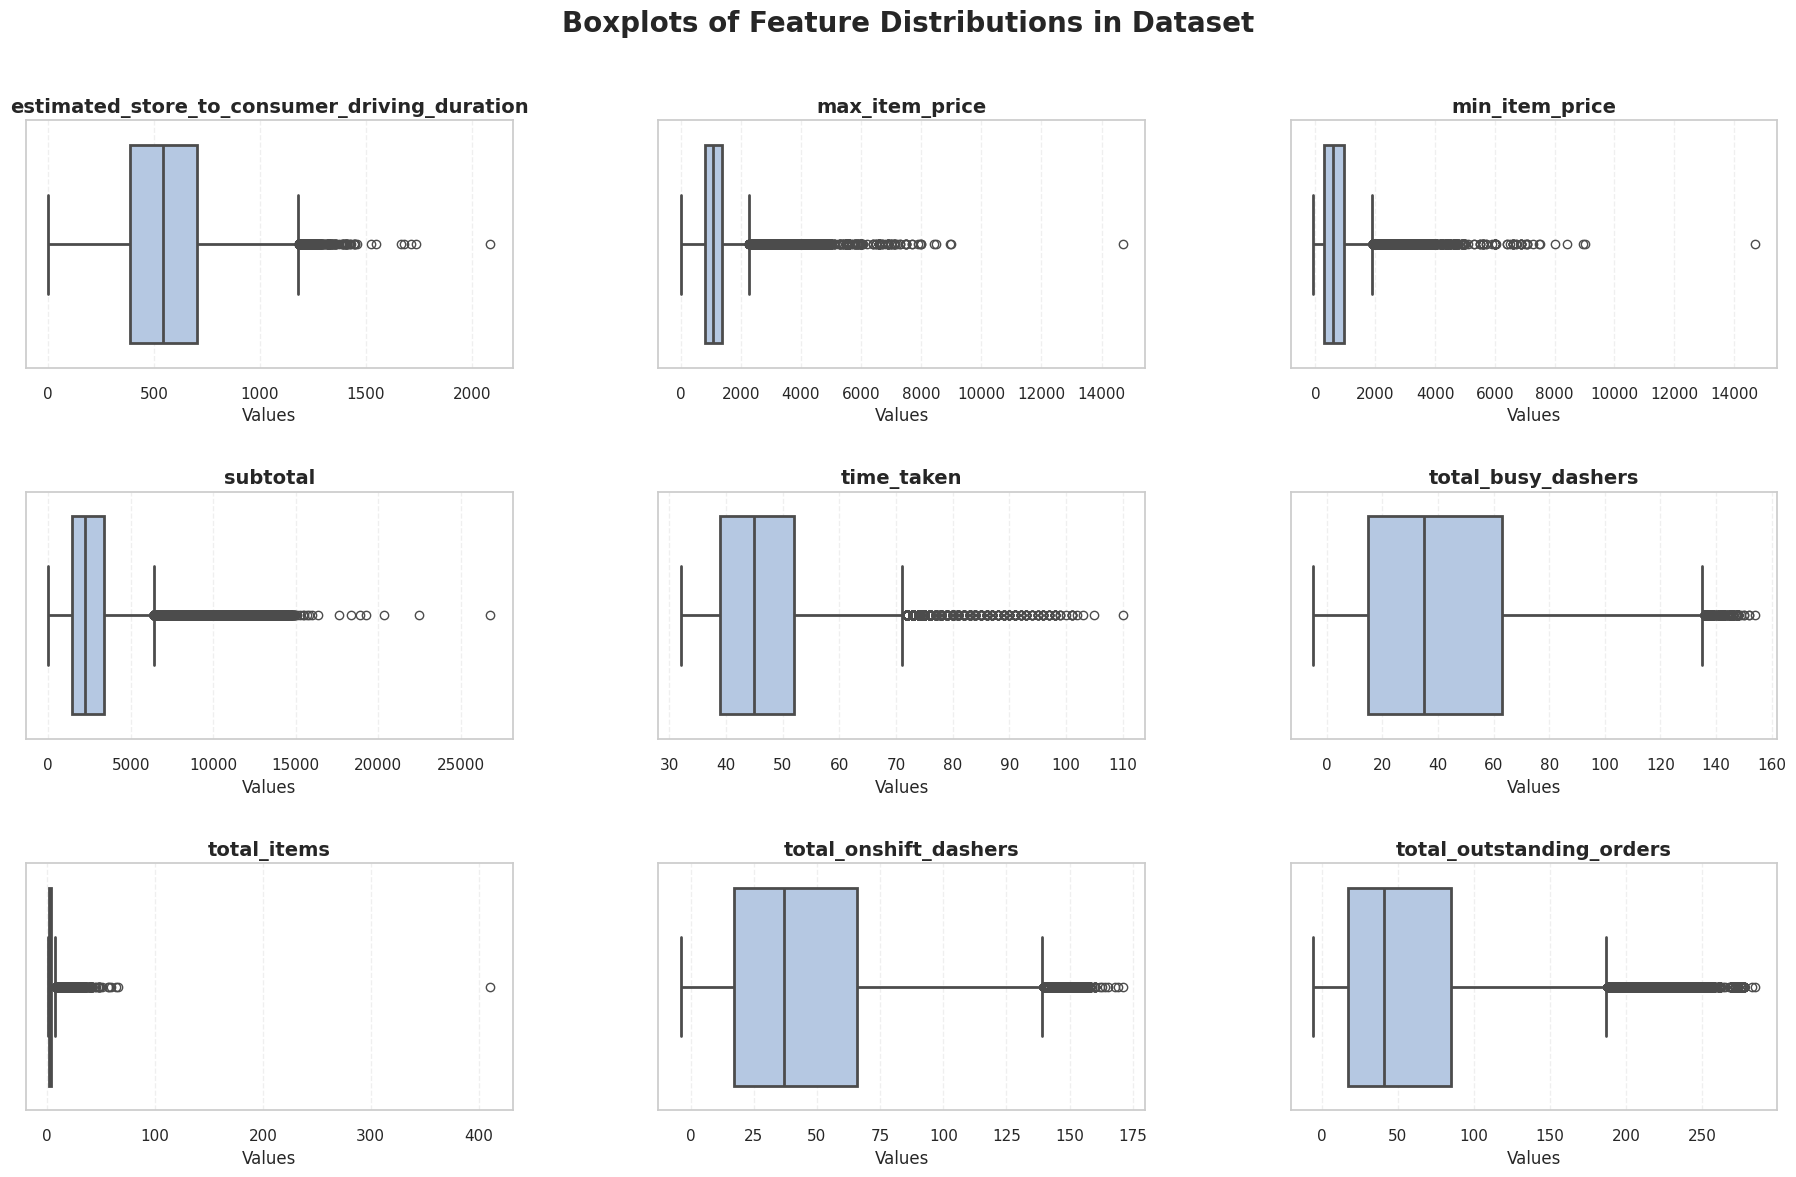

In [22]:
outliers_columns = Original_df_outliers[
    (Original_df_outliers['IQR Outlier Count'] > 0) |
    (Original_df_outliers['Z-Score Outlier Count'] > 0)
].index
Original_df_analyzer.plot_boxplot(outliers_columns, "Boxplot of Various Distributions", "Values")

In [23]:
df_outliers_columns_df = Original_df_outliers[
    (Original_df_outliers['IQR Outlier Count'] > 0) |
    (Original_df_outliers['Z-Score Outlier Count'] > 0)
].copy()
df_outliers_columns_df = Original_df_analyzer.suggest_capping_thresholds(df_outliers_columns_df)

In [24]:
# capped outliers
outliers_columns = df_outliers_columns_df.index
#for col in outliers_columns:
#    df_transformed_analyzer.cap_outliers(col, df_transformed_outliers_columns_df.loc[col, 'Suggested Lower Percentile'], df_transformed_outliers_columns_df.loc[col, 'Suggested Upper Percentile'])

# Handle LOF-based outliers
#lof_outliers = df_transformed_analyzer.detect_outliers_lof()

for col in outliers_columns:
    Original_df_analyzer.cap_lof_outliers(col, lower_percentile=df_outliers_columns_df.loc[col, 'Suggested Lower Percentile'], upper_percentile=df_outliers_columns_df.loc[col, 'Suggested Upper Percentile'])


✅ LOF outliers in 'estimated_store_to_consumer_driving_duration' capped between 2nd and 98th percentile.
✅ LOF outliers in 'max_item_price' capped between 1st and 93rd percentile.
✅ LOF outliers in 'min_item_price' capped between 1st and 93rd percentile.
✅ LOF outliers in 'subtotal' capped between 1st and 93rd percentile.
✅ LOF outliers in 'time_taken' capped between 1st and 93rd percentile.
✅ LOF outliers in 'total_busy_dashers' capped between 2nd and 98th percentile.
✅ LOF outliers in 'total_items' capped between 1st and 93rd percentile.
✅ LOF outliers in 'total_onshift_dashers' capped between 1st and 93rd percentile.
✅ LOF outliers in 'total_outstanding_orders' capped between 1st and 93rd percentile.


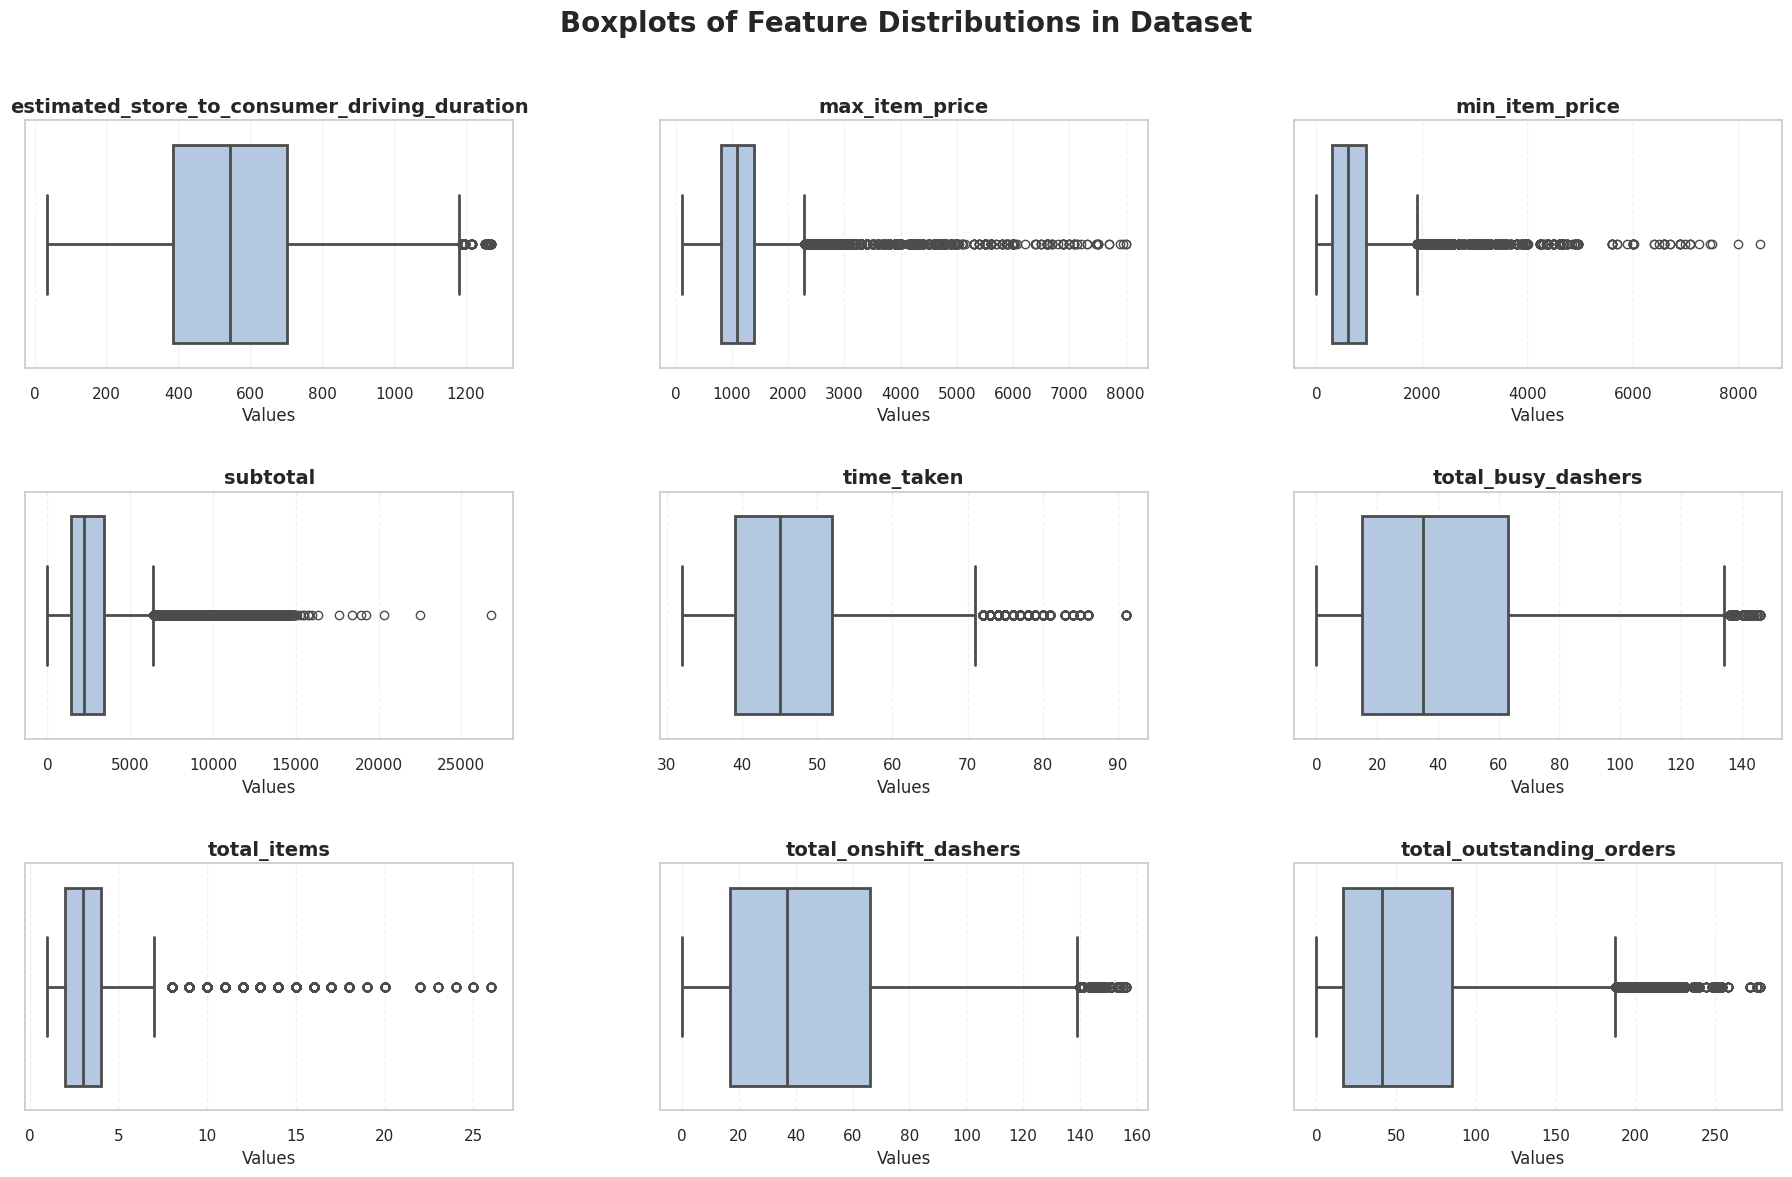

In [25]:
Original_df_analyzer.plot_boxplot(outliers_columns, "Boxplot of Various Distributions", "Values")

- Before removal, boxplots exhibit heavy right skew and extensive extreme outliers across features like subtotal and total_outstanding_orders.

- LOF capping dramatically reduces whisker lengths and tightens IQRs, removing most extreme anomalies.

- Post-treatment distributions are more balanced, with only a few mild outliers remaining, improving data robustness.



> # Exploratory data analysis



In [26]:
class EDAVisualizer:
    def __init__(self, df):
        self.df = df.copy()
        self.important_numerical_pairs = []
        self.important_categorical_pairs = []

    # -------------------- Feature Importance --------------------
    def calculate_important_features(self, correlation_threshold=0.5, max_categories=29, target_col=None):
        # Numerical feature pairs based on Pearson correlation
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        correlation_matrix = self.df[numerical_cols].corr()

        for i in range(len(numerical_cols)):
            for j in range(i + 1, len(numerical_cols)):
                if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                    self.important_numerical_pairs.append((numerical_cols[i], numerical_cols[j]))

        # Categorical features using Chi-squared test
        categorical_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns

        if target_col and target_col in self.df.columns and self.df[target_col].dtype in ['object', 'category', 'bool']:
            for col in categorical_cols:
                if col == target_col:
                    continue
                if self.df[col].nunique() <= max_categories:
                    try:
                        contingency_table = pd.crosstab(self.df[target_col], self.df[col])
                        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                            chi2, p_val, _, _ = chi2_contingency(contingency_table)
                            if p_val < 0.05:
                                self.important_categorical_pairs.append((target_col, col))
                    except Exception as e:
                        print(f"⚠️ Skipping chi-squared test for {col} due to error: {e}")
                        continue

        return self.important_numerical_pairs, self.important_categorical_pairs

    def get_important_columns(self):
        important_num_cols = list(set(col for pair in self.important_numerical_pairs for col in pair))
        important_cat_cols = list(set(col for pair in self.important_categorical_pairs for col in pair))
        return important_num_cols, important_cat_cols

    # -------------------- Univariate Analysis --------------------
    def univariate_analysis(self, imp_cols_viz=True, show_violin=False):
        print("\n--- Univariate Analysis ---")

        numerical_cols = []
        categorical_cols = []

        if imp_cols_viz:
            if self.important_numerical_pairs:
                numerical_cols = list(set([col for pair in self.important_numerical_pairs for col in pair]))
            else:
                print("⚠️ No important numerical pairs found.")
            if self.important_categorical_pairs:
                categorical_cols = list(set([col for pair in self.important_categorical_pairs for col in pair]))
            else:
                print("⚠️ No important categorical pairs found.")
        else:
            numerical_cols = self.df.select_dtypes(include=[np.number]).columns
            categorical_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns

        # Numerical plots
        for col in numerical_cols:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            sns.histplot(self.df[col], kde=True, bins=20, color='skyblue', ax=axes[0])
            axes[0].set_title(f"Histogram with KDE: {col}")
            sns.boxplot(x=self.df[col], color='orange', ax=axes[1])
            axes[1].set_title(f"Boxplot: {col}")
            if show_violin:
                sns.violinplot(x=self.df[col], color='lightgreen', ax=axes[2])
                axes[2].set_title(f"Violinplot: {col}")
            else:
                axes[2].set_visible(False)
            plt.tight_layout()
            plt.show()

        # Categorical plots
        for col in categorical_cols:
            plt.figure(figsize=(8, 4))
            sns.countplot(data=self.df, x=col, palette='pastel')
            plt.title(f"Countplot: {col}")
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()

    # -------------------- Bivariate Analysis --------------------
    def bivariate_analysis(self, correlation_threshold=0.5, max_categories=29, imp_cols_viz=True, show_violin=False):
        print("\n--- Bivariate Analysis ---")

        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

        if imp_cols_viz:
            if self.important_numerical_pairs:
                numerical_cols = list(set([col for pair in self.important_numerical_pairs for col in pair]))
            if self.important_categorical_pairs:
                categorical_cols = list(set([col for pair in self.important_categorical_pairs for col in pair]))

        # Numerical vs Numerical
        num_num_pairs = [
            (col1, col2) for i, col1 in enumerate(numerical_cols)
            for j, col2 in enumerate(numerical_cols)
            if i < j and abs(self.df[col1].corr(self.df[col2])) >= correlation_threshold
        ]

        for i in range(0, len(num_num_pairs), 3):
            fig, axes = plt.subplots(1, 3, figsize=(20, 5))
            for j, (x_col, y_col) in enumerate(num_num_pairs[i:i+3]):
                sns.scatterplot(data=self.df, x=x_col, y=y_col, ax=axes[j])
                axes[j].set_title(f"{x_col} vs {y_col}")
            for k in range(len(num_num_pairs[i:i+3]), 3):
                fig.delaxes(axes[k])
            plt.tight_layout()
            plt.show()

        # Numerical vs Categorical
        num_cat_pairs = [
            (num_col, cat_col)
            for num_col in numerical_cols
            for cat_col in categorical_cols
            if self.df[cat_col].nunique() <= max_categories
        ]

        for i in range(0, len(num_cat_pairs), 3):
            fig, axes = plt.subplots(1, 3, figsize=(20, 5))
            for j, (num_col, cat_col) in enumerate(num_cat_pairs[i:i+3]):
                if show_violin:
                    sns.violinplot(x=self.df[cat_col], y=self.df[num_col], palette='Set2', ax=axes[j])
                else:
                    sns.boxplot(x=self.df[cat_col], y=self.df[num_col], palette='Set2', ax=axes[j])
                axes[j].set_title(f"{num_col} by {cat_col}")
                axes[j].tick_params(axis='x', rotation=90)
            for k in range(len(num_cat_pairs[i:i+3]), 3):
                fig.delaxes(axes[k])
            plt.tight_layout()
            plt.show()

        # Categorical vs Categorical
        cat_cat_pairs = [
            (col1, col2) for i, col1 in enumerate(categorical_cols)
            for j, col2 in enumerate(categorical_cols)
            if i < j and self.df[col1].nunique() <= max_categories and self.df[col2].nunique() <= max_categories
        ]

        for i in range(0, len(cat_cat_pairs), 3):
            fig, axes = plt.subplots(1, 3, figsize=(20, 5))
            for j, (col1, col2) in enumerate(cat_cat_pairs[i:i+3]):
                grouped = self.df.groupby([col1, col2]).size().reset_index(name='Count')
                sns.barplot(data=grouped, x=col1, y='Count', hue=col2, ax=axes[j], palette='pastel')
                axes[j].set_title(f"{col1} vs {col2}")
                axes[j].tick_params(axis='x', rotation=90)
                axes[j].legend(title=col2)
            for k in range(len(cat_cat_pairs[i:i+3]), 3):
                fig.delaxes(axes[k])
            plt.tight_layout()
            plt.show()

    # -------------------- Multivariate Analysis --------------------
    def multivariate_analysis(self, imp_cols_viz=True, correlation_threshold=0.5, max_categories=29,
                              target_col=None, show_pairplot=True, show_violin=False):
        print("\n--- Multivariate Analysis ---")

        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

        if imp_cols_viz:
            if self.important_numerical_pairs:
                numerical_cols = list(set([col for pair in self.important_numerical_pairs for col in pair]))
            if self.important_categorical_pairs:
                categorical_cols = list(set([col for pair in self.important_categorical_pairs for col in pair]))

        # Numerical pairplot and heatmap
        if len(numerical_cols) >= 2:
            if show_pairplot:
                sns.pairplot(self.df[numerical_cols], corner=True)
                plt.suptitle("Pairwise Plot for Numerical Features", y=1.02)
                plt.show()

            corr_matrix = self.df[numerical_cols].corr()
            filtered_corr = corr_matrix.copy()
            mask = abs(filtered_corr) < correlation_threshold
            filtered_corr[mask] = 0
            plt.figure(figsize=(12, 8))
            sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
            plt.title("Correlation Heatmap for Numerical Features")
            plt.show()

    # -------------------- Helper Plots --------------------
    def plot_countplot(self, col, rotate_xticks=True):
        if col not in self.df.columns:
            print(f"❌ Column '{col}' not found.")
            return
        plt.figure(figsize=(8, 4))
        sns.countplot(data=self.df, x=col, palette='pastel')
        plt.title(f"Countplot: {col}")
        if rotate_xticks:
            plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def plot_histplot(self, col, bins=20, kde=True):
        if col not in self.df.columns:
            print(f"❌ Column '{col}' not found.")
            return
        if not np.issubdtype(self.df[col].dtype, np.number):
            print(f"⚠️ Column '{col}' is not numeric. Skipping histogram.")
            return
        plt.figure(figsize=(8, 4))
        sns.histplot(self.df[col], bins=bins, kde=kde, color='skyblue')
        plt.title(f"Histogram: {col}")
        plt.tight_layout()
        plt.show()

    def plot_density(self, col):
        if col not in self.df.columns:
            print(f"❌ Column '{col}' not found.")
            return
        if not np.issubdtype(self.df[col].dtype, np.number):
            print(f"⚠️ Column '{col}' is not numeric. Skipping density plot.")
            return
        plt.figure(figsize=(8, 4))
        sns.kdeplot(self.df[col], fill=True, color='purple')
        plt.title(f"Density Plot (KDE): {col}")
        plt.tight_layout()
        plt.show()

    def plot_heatmap(self, columns=None, annot=True, threshold=None):
        if columns is None:
            columns = self.df.select_dtypes(include=[np.number]).columns
        corr = self.df[columns].corr()
        if threshold:
            mask = abs(corr) < threshold
            corr = corr.mask(mask)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=annot, cmap='coolwarm', linewidths=0.5, fmt='.2f')
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    def plot_grid_of_columns(self, columns, plots_per_row=3):
        num_plots = len(columns)
        rows = math.ceil(num_plots / plots_per_row)
        fig, axes = plt.subplots(rows, plots_per_row, figsize=(6 * plots_per_row, 4 * rows))
        axes = axes.flatten() if num_plots > 1 else [axes]

        for i, col in enumerate(columns):
            ax = axes[i]
            if col not in self.df.columns:
                ax.set_visible(False)
                continue
            if pd.api.types.is_numeric_dtype(self.df[col]):
                sns.histplot(self.df[col].dropna(), kde=True, ax=ax, color='skyblue')
                ax.set_title(f"Histogram: {col}")
            else:
                value_counts = self.df[col].value_counts()
                if len(value_counts) > 50:
                    top_categories = value_counts.nlargest(20).index
                    temp_series = self.df[col].apply(lambda x: x if x in top_categories else 'Other')
                    sns.countplot(x=temp_series, ax=ax, palette='pastel', order=temp_series.value_counts().index)
                    ax.set_title(f"Top 20 Countplot (rest as 'Other'): {col}")
                else:
                    sns.countplot(data=self.df, x=col, ax=ax, palette='pastel', order=value_counts.index)
                    ax.set_title(f"Countplot: {col}")
                ax.tick_params(axis='x', rotation=90)
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        plt.tight_layout()
        plt.show()


In [27]:
eda_visualizer = EDAVisualizer(df)

In [28]:
# Detect important numerical/categorical relationships
important_num, important_cat = eda_visualizer.calculate_important_features(
    correlation_threshold=0.5,
    max_categories=29,
    target_col='time_taken'  # optional: if you have a supervised target
)

print("Important numerical pairs:", important_num)
print("Important categorical pairs:", important_cat)

Important numerical pairs: [('total_items', 'subtotal'), ('subtotal', 'max_item_price'), ('min_item_price', 'max_item_price'), ('total_onshift_dashers', 'total_busy_dashers'), ('total_onshift_dashers', 'total_outstanding_orders'), ('total_busy_dashers', 'total_outstanding_orders')]
Important categorical pairs: []



--- Univariate Analysis ---
⚠️ No important categorical pairs found.


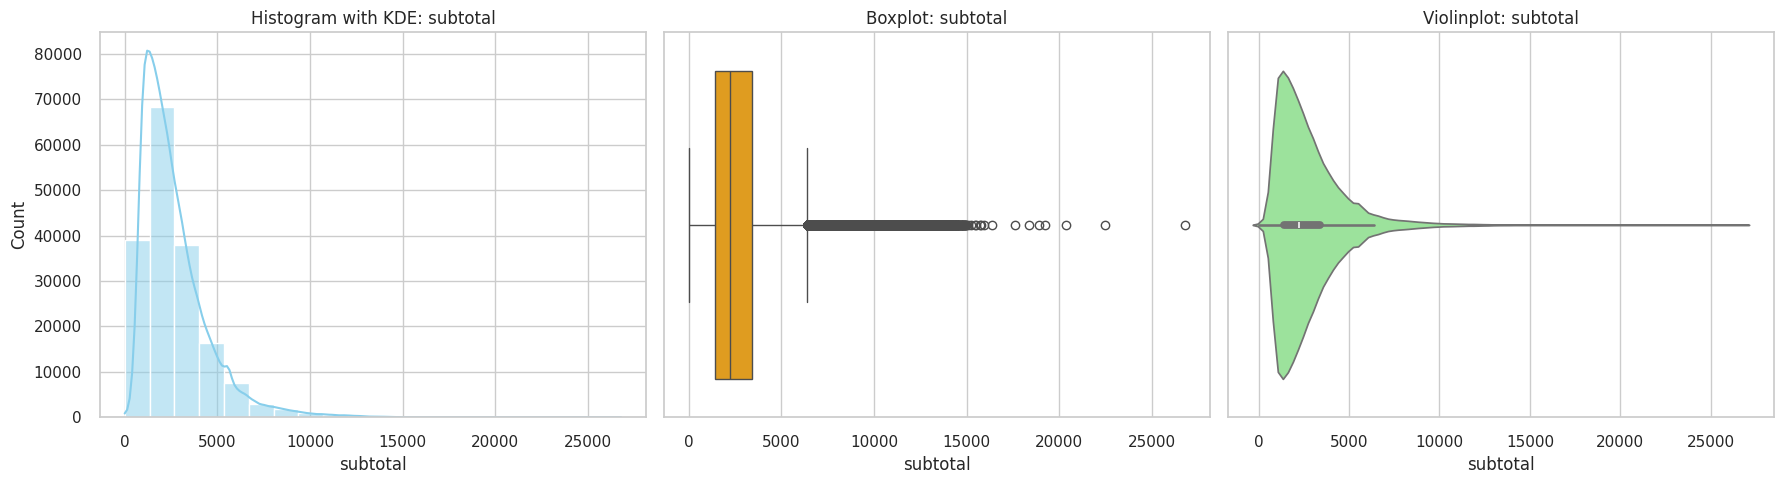

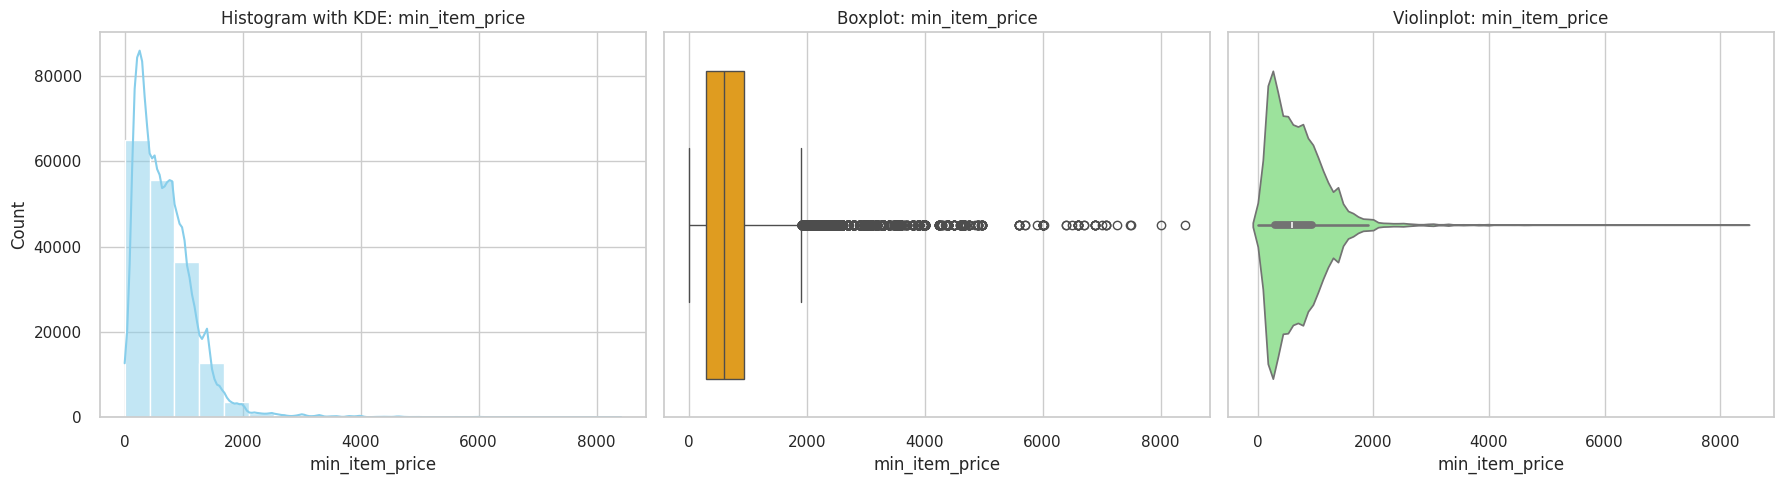

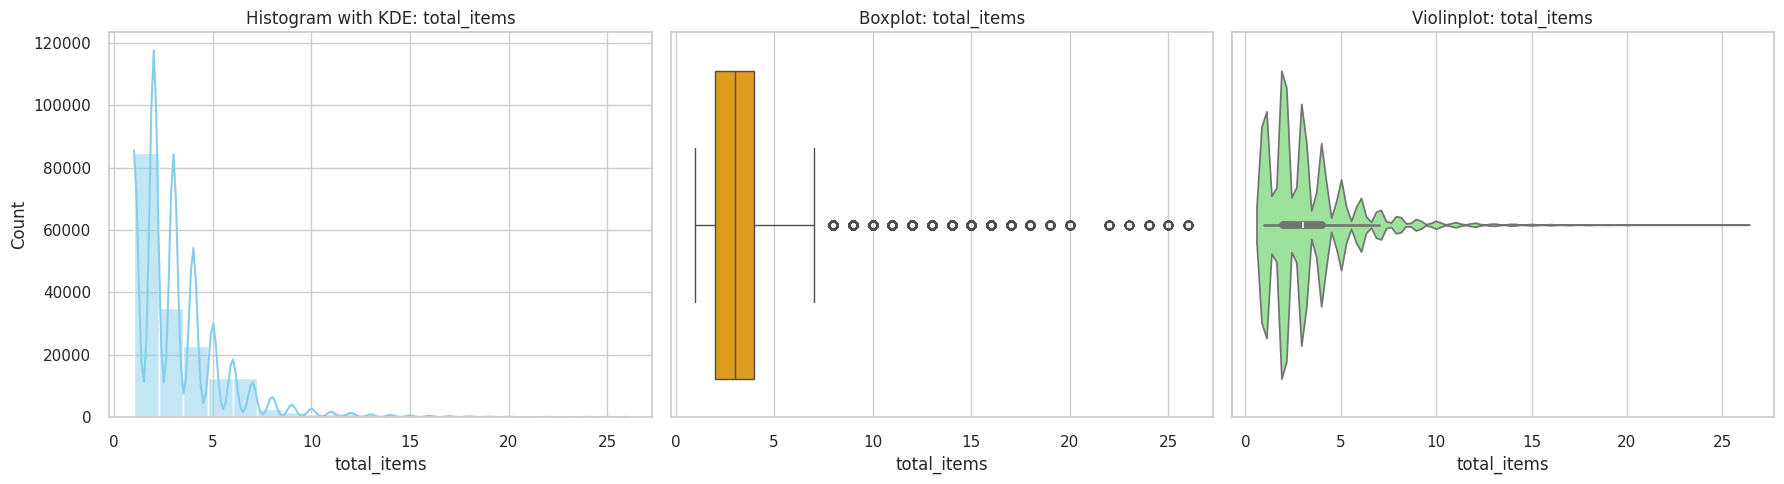

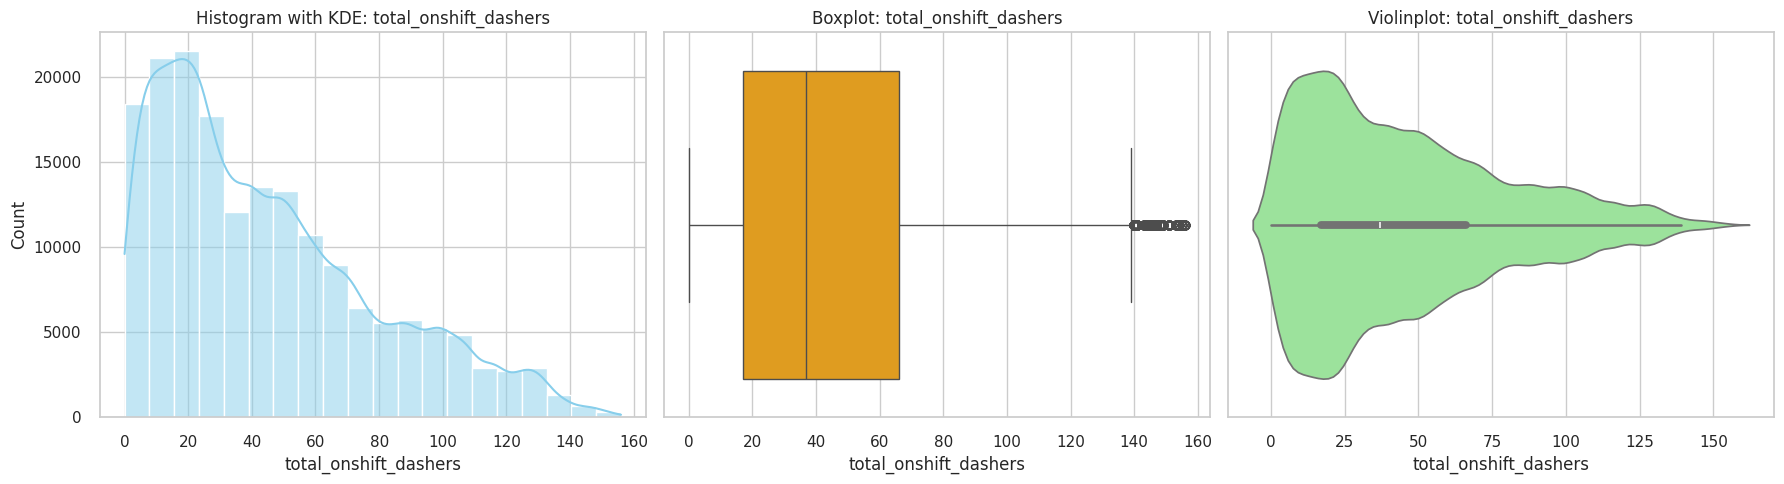

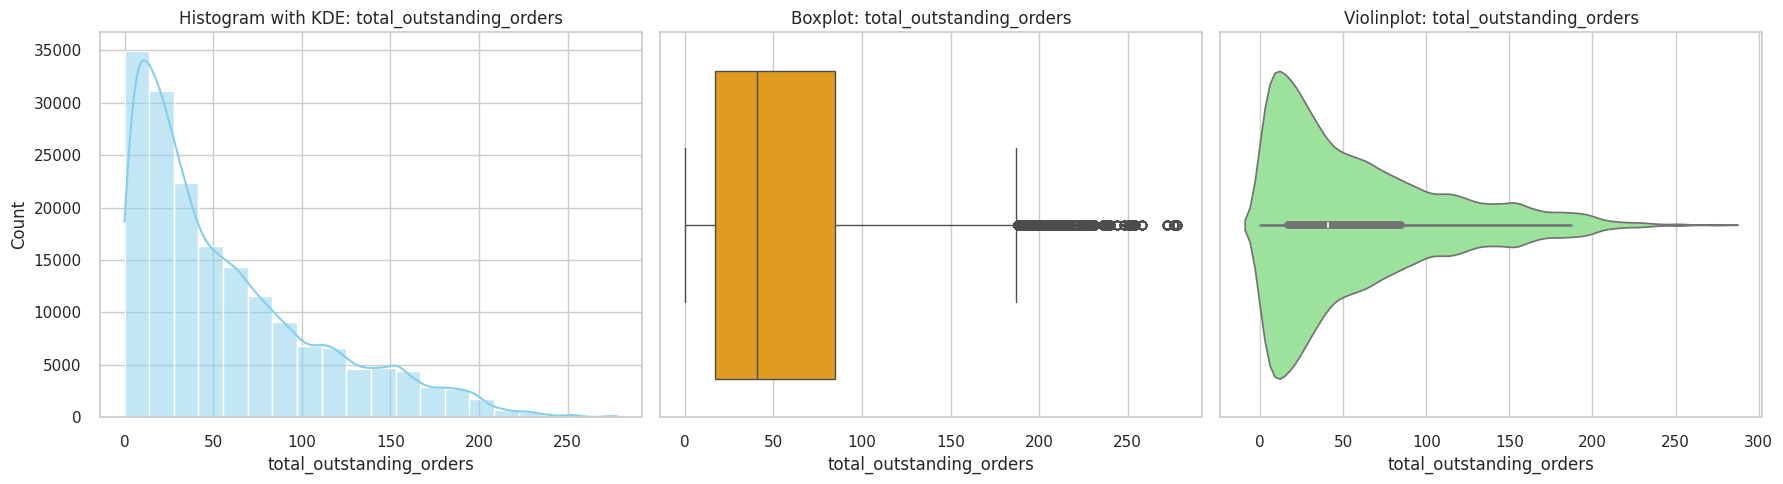

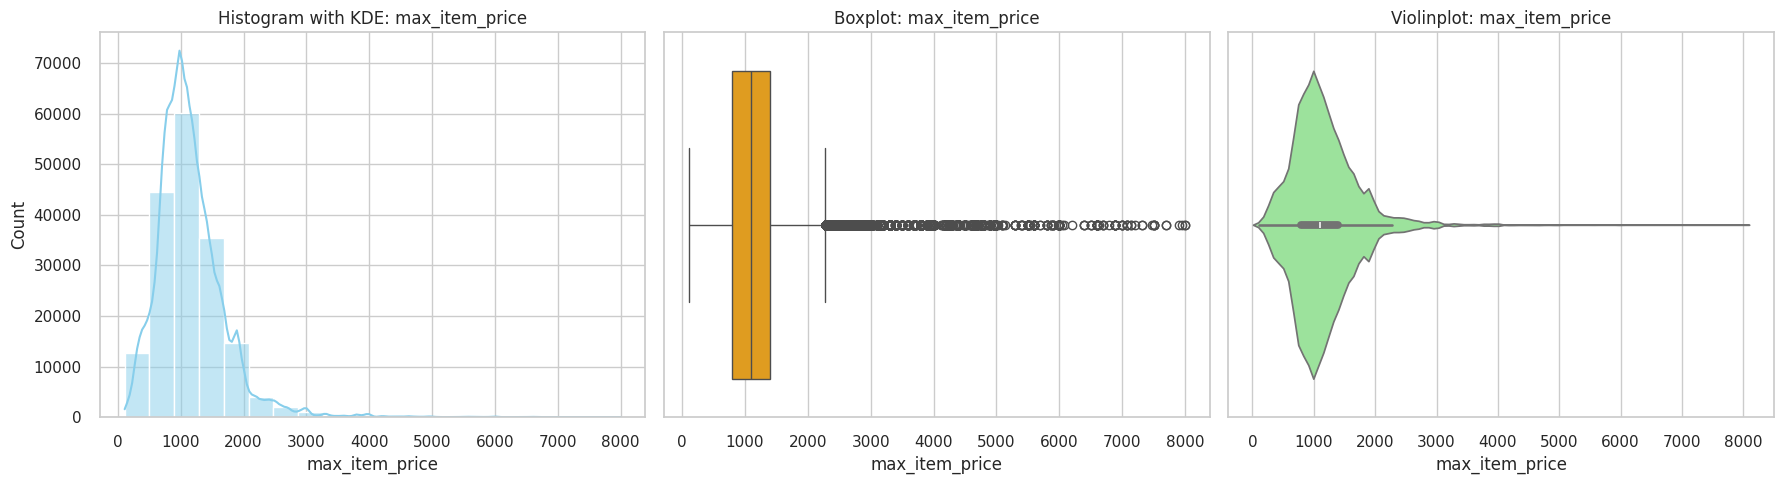

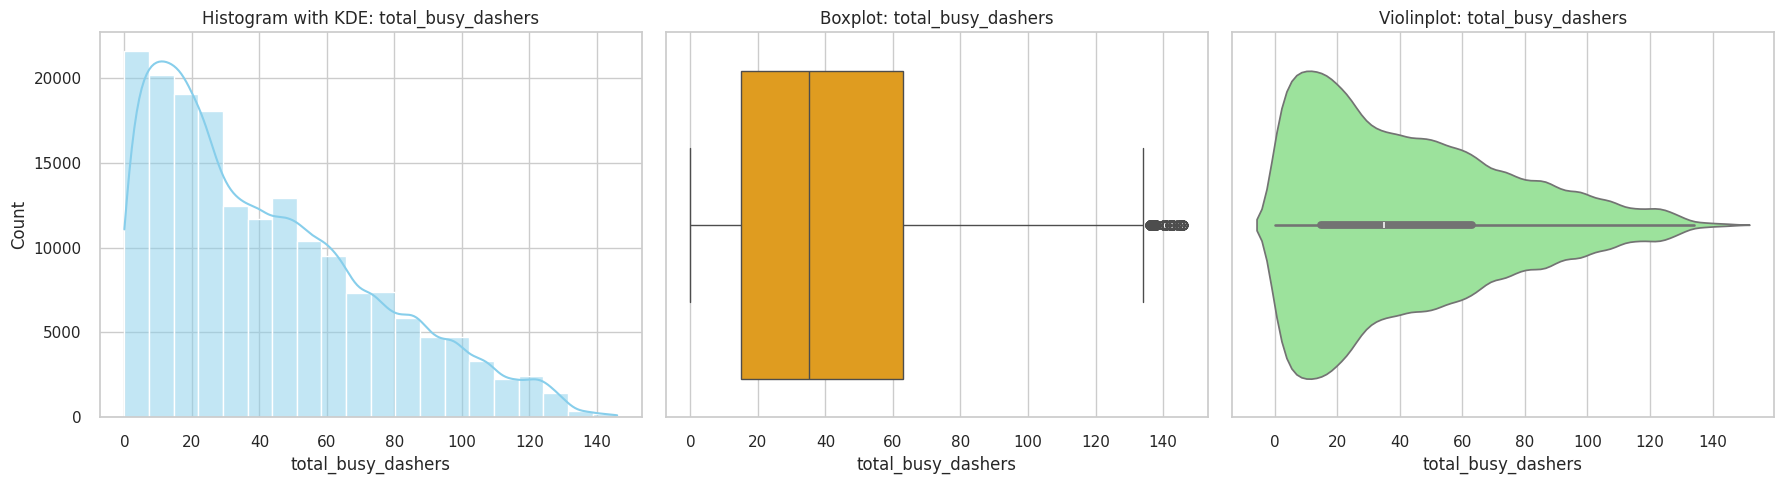

In [29]:
# Basic univariate distributions
eda_visualizer.univariate_analysis(
    imp_cols_viz=True,  # use only important features if True
    show_violin=True    # show violin plots along with boxplots
)



--- Bivariate Analysis ---


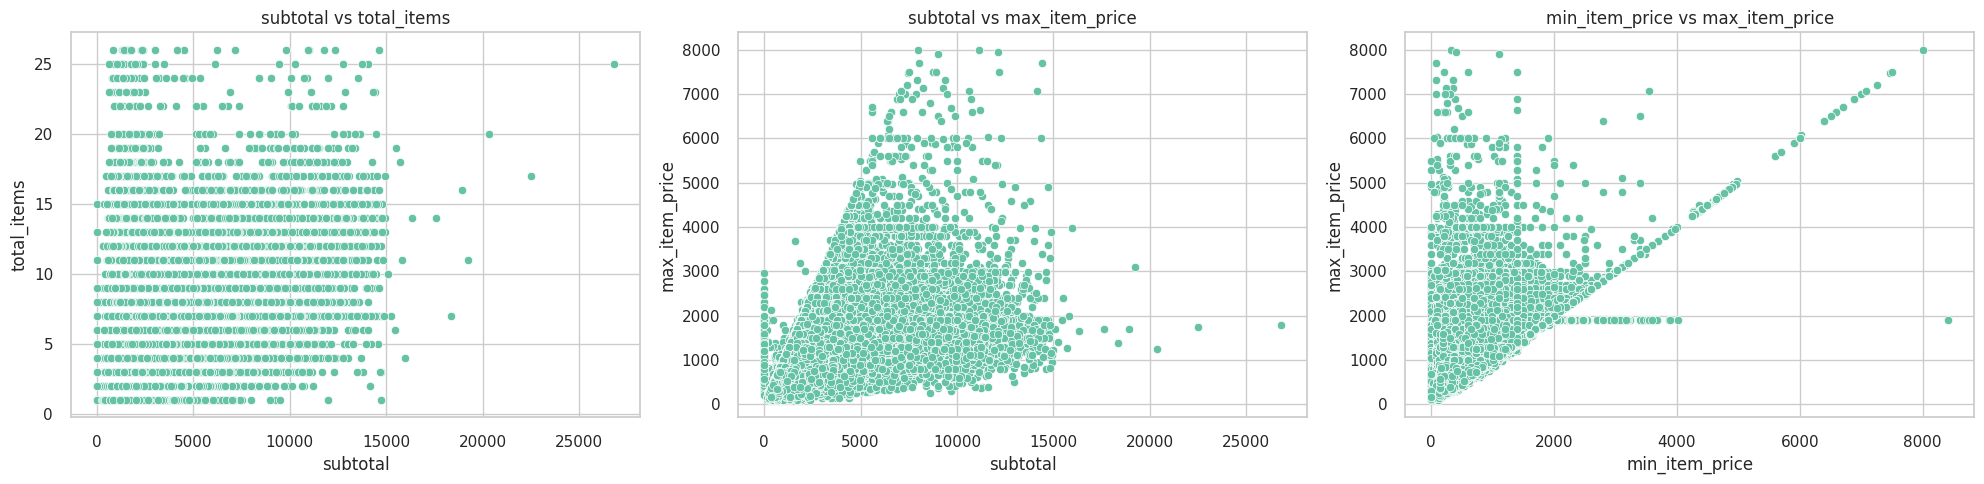

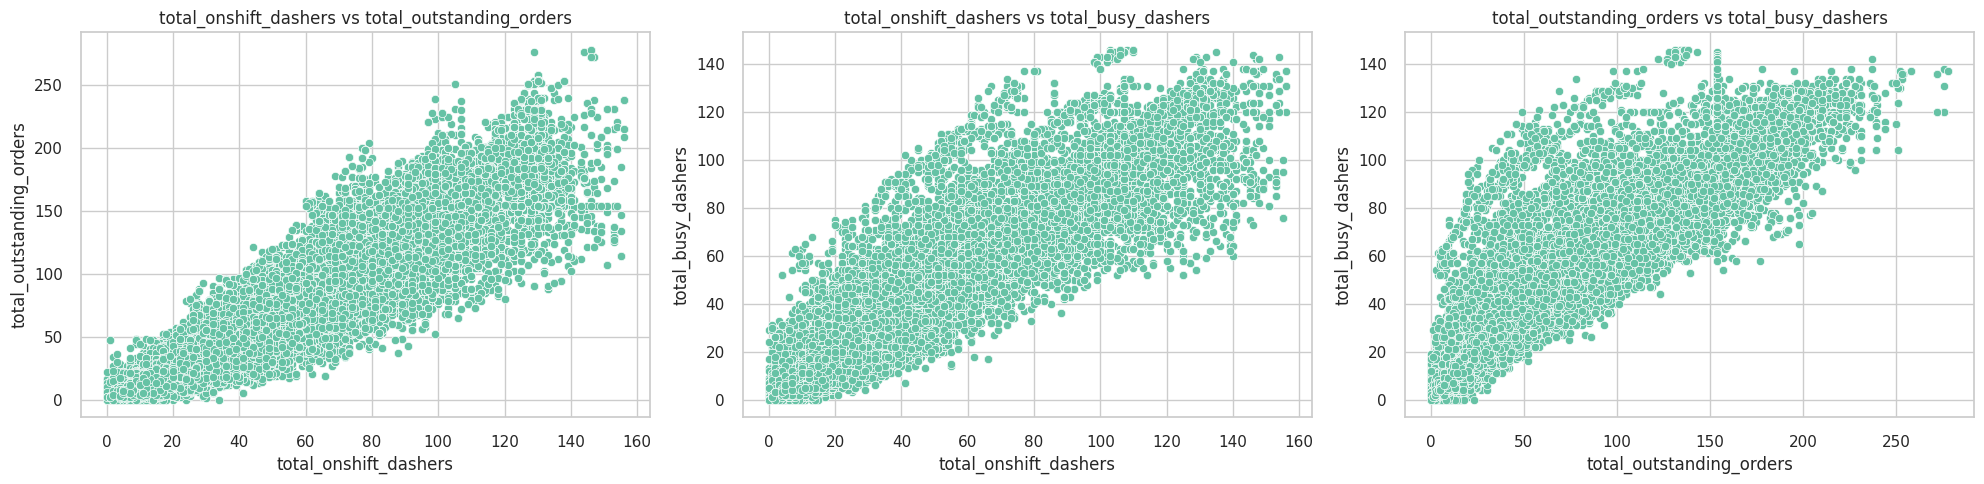

2025-10-21 14:36:43,685 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:43,798 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:44,029 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:44,147 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:44,346 - INFO - Using categorical units to plot a list of strings that are all parsable as 

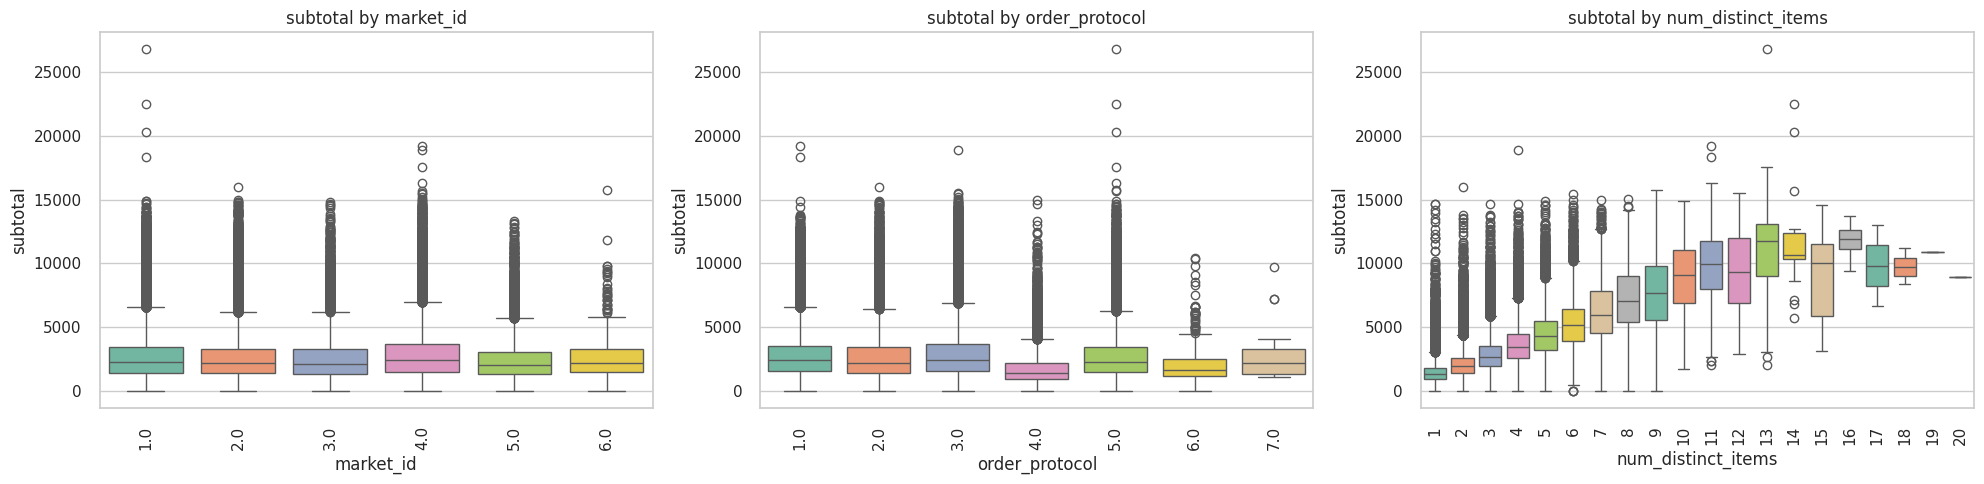

2025-10-21 14:36:45,159 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:45,273 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:45,488 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:45,605 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:45,799 - INFO - Using categorical units to plot a list of strings that are all parsable as 

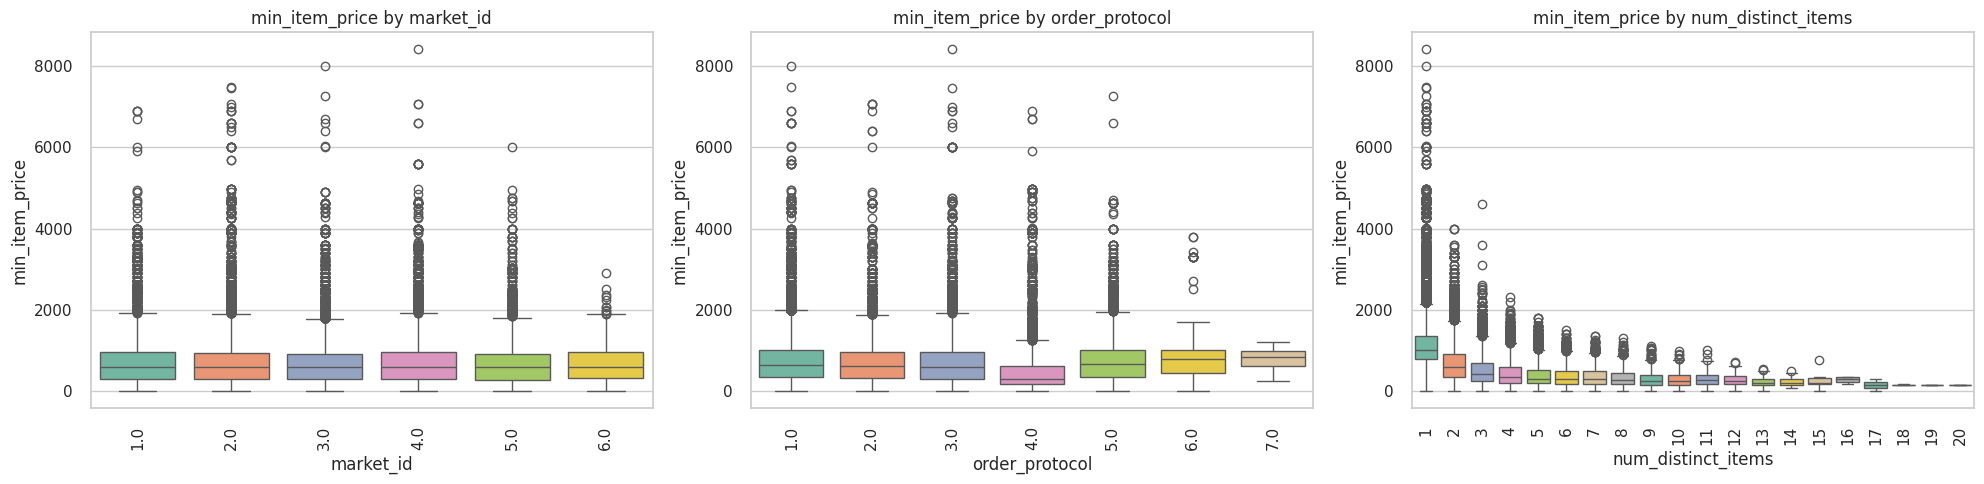

2025-10-21 14:36:46,858 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:47,067 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:47,387 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:47,591 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:47,894 - INFO - Using categorical units to plot a list of strings that are all parsable as 

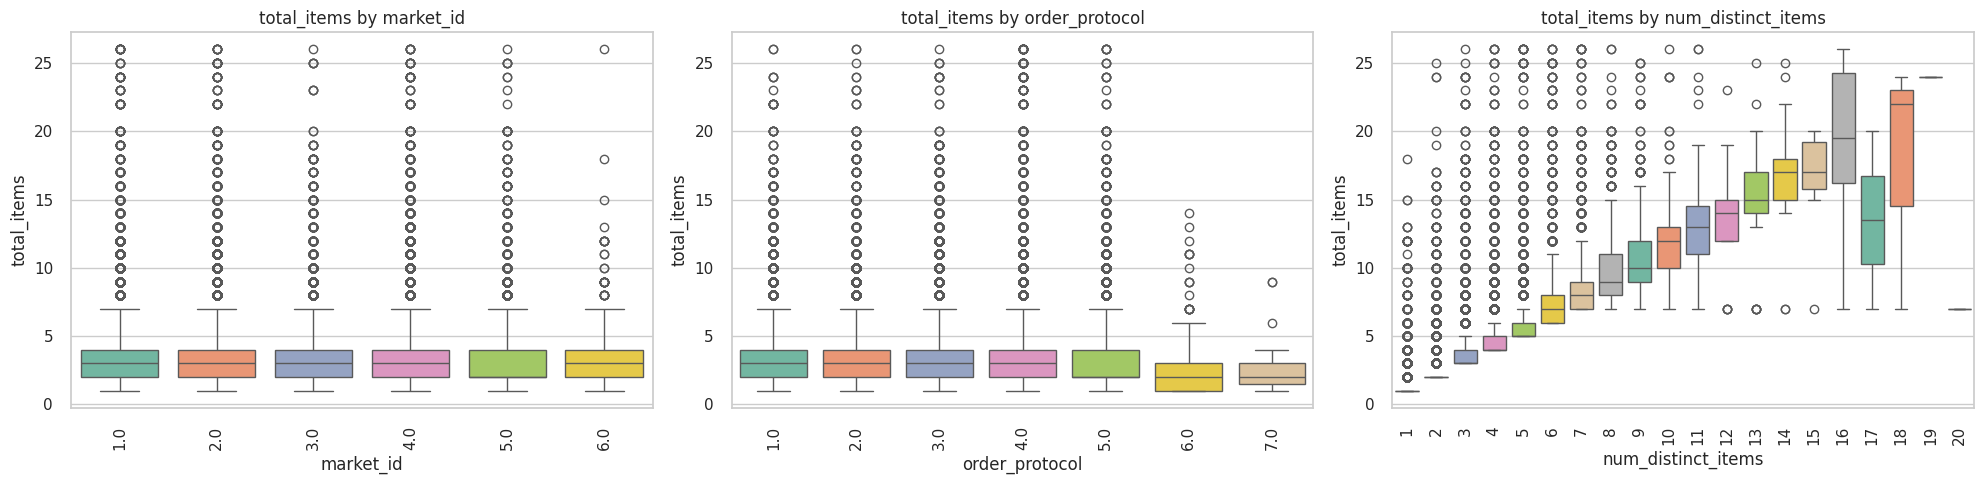

2025-10-21 14:36:48,845 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:48,977 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:49,215 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:49,343 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:49,551 - INFO - Using categorical units to plot a list of strings that are all parsable as 

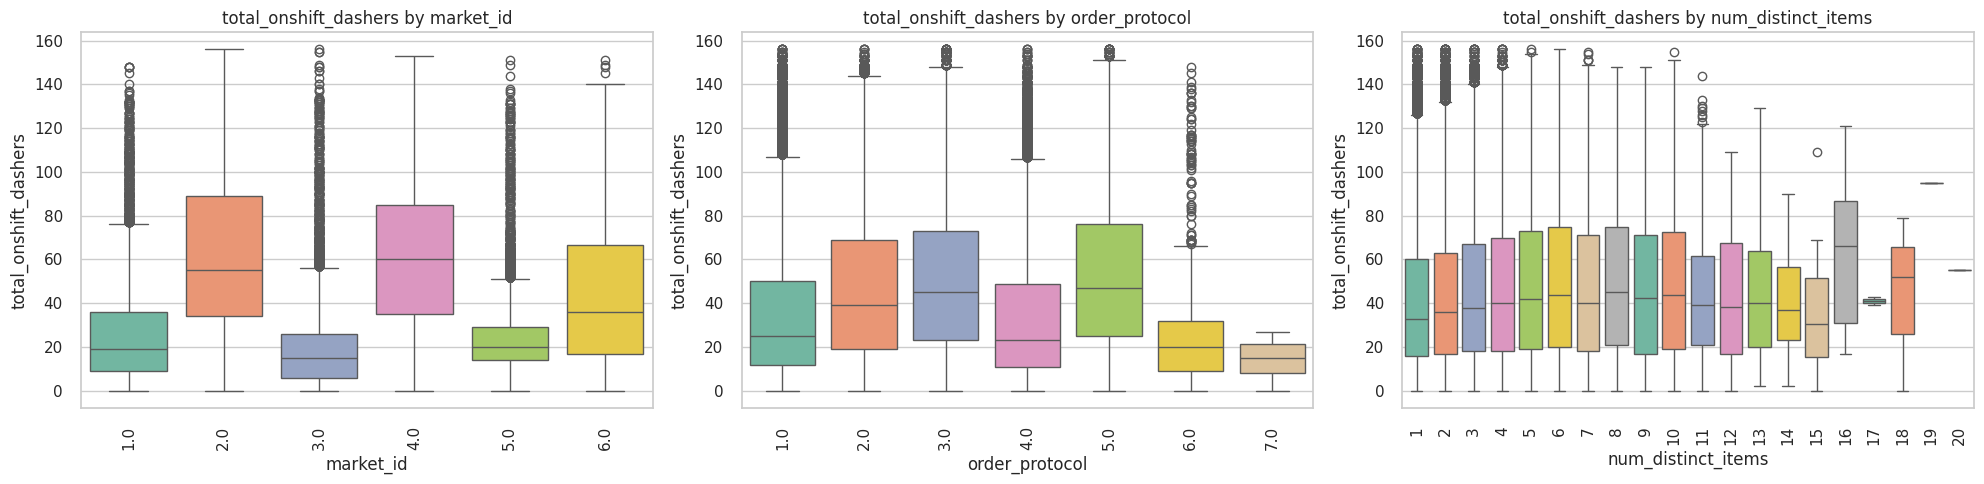

2025-10-21 14:36:50,386 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:50,520 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:50,748 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:50,879 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:51,087 - INFO - Using categorical units to plot a list of strings that are all parsable as 

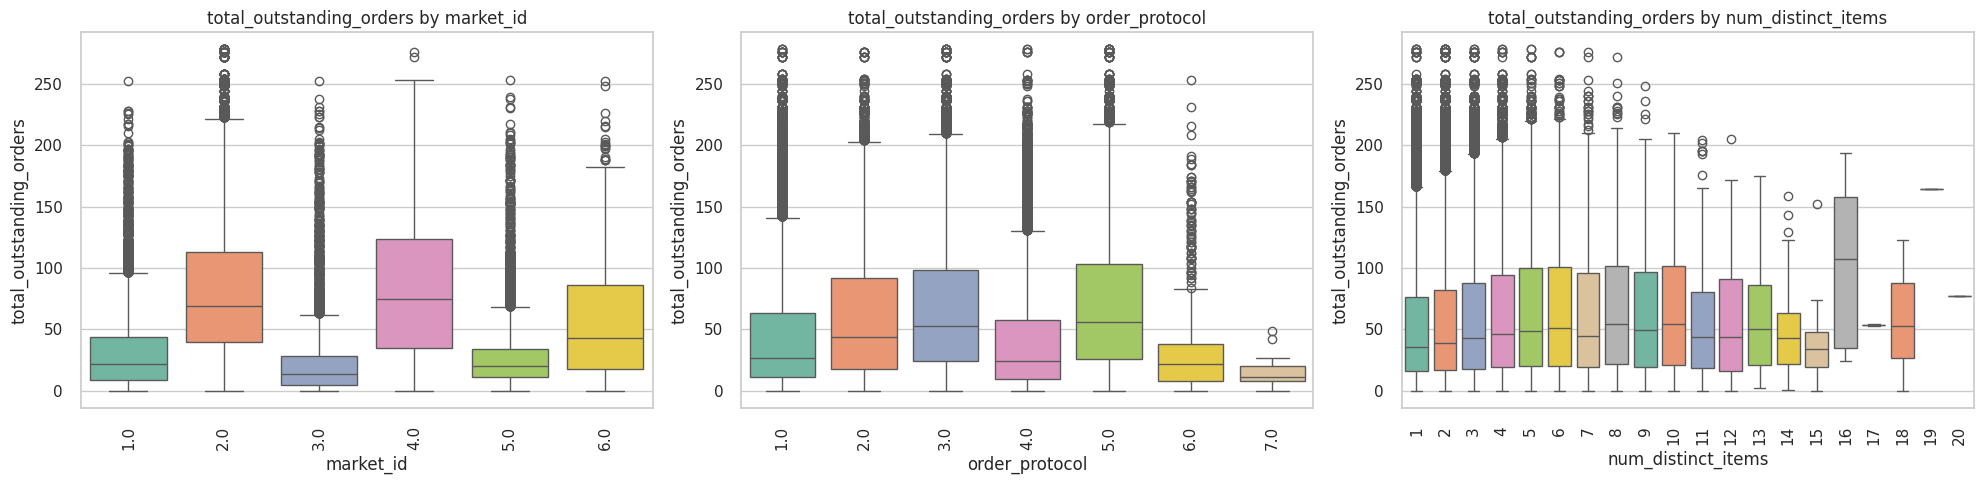

2025-10-21 14:36:51,918 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:52,041 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:52,267 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:52,389 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:52,584 - INFO - Using categorical units to plot a list of strings that are all parsable as 

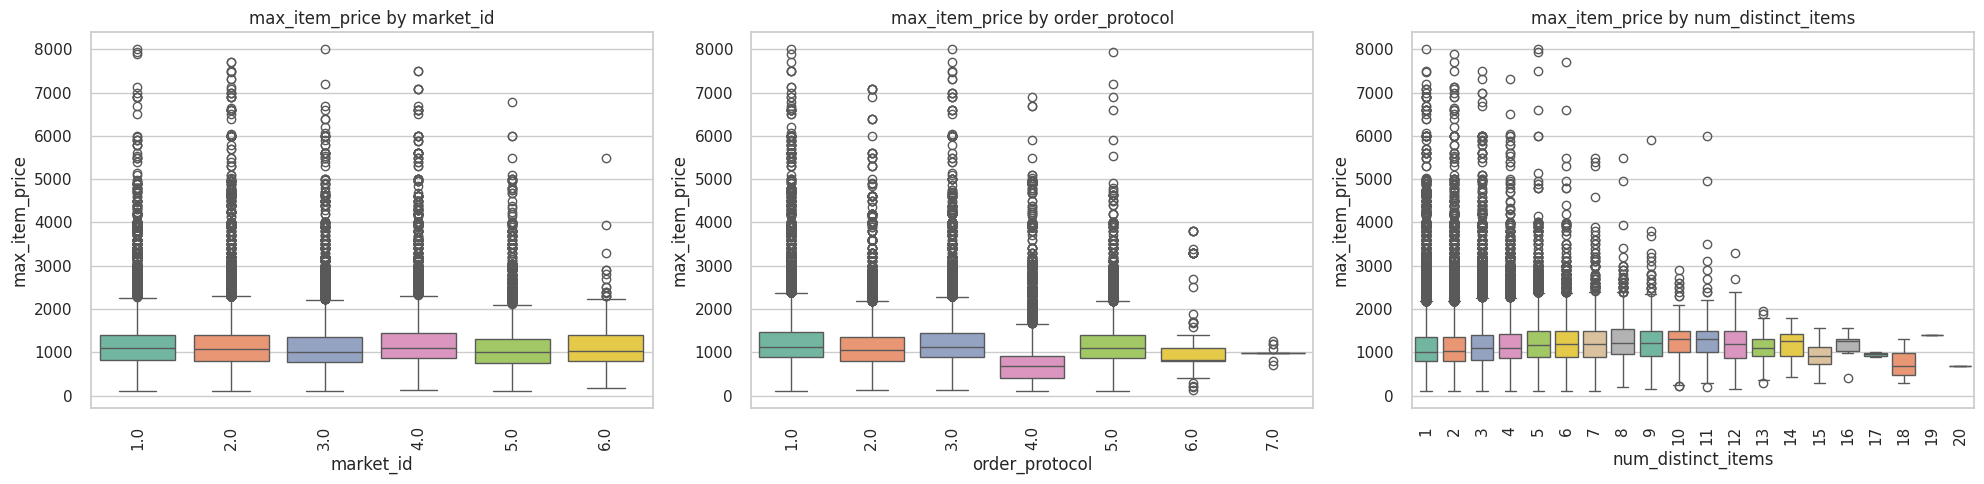

2025-10-21 14:36:53,962 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:54,106 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:54,324 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:54,452 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:54,638 - INFO - Using categorical units to plot a list of strings that are all parsable as 

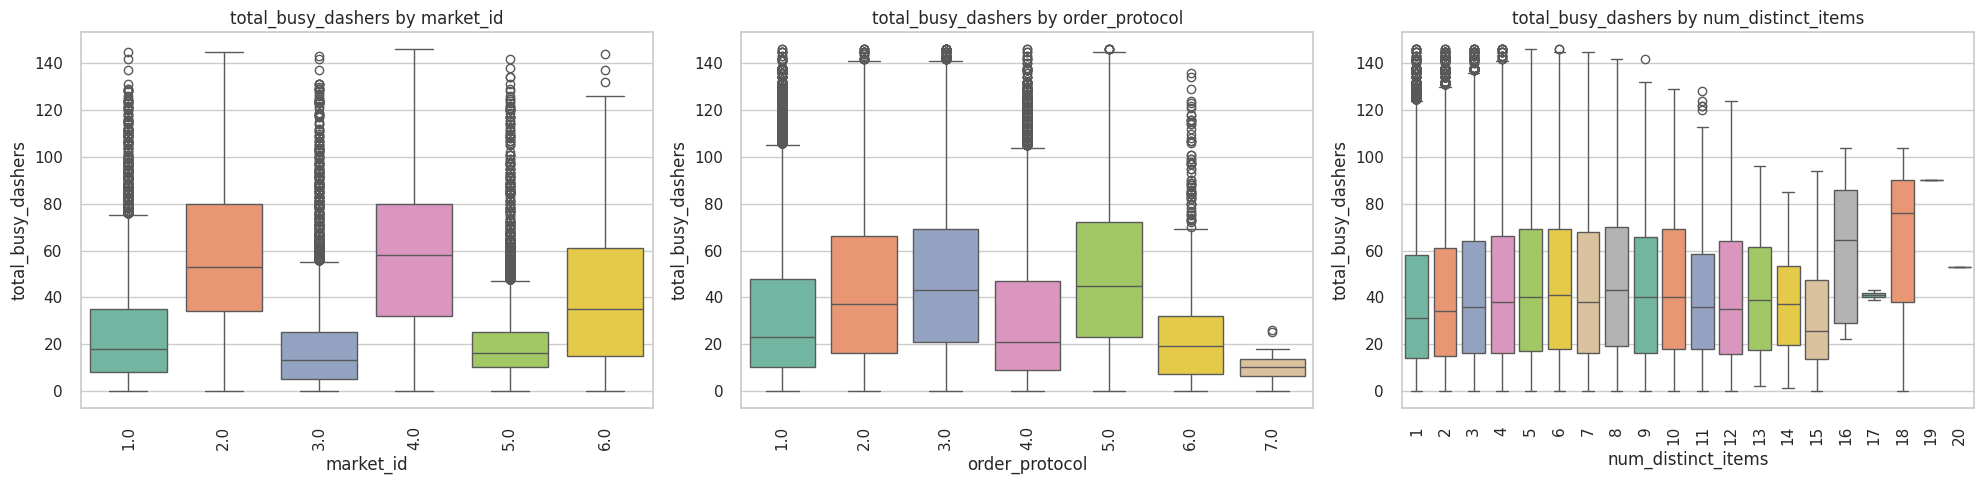

2025-10-21 14:36:55,424 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:55,432 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:55,556 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:55,560 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 14:36:55,835 - INFO - Using categorical units to plot a list of strings that are all parsable as 

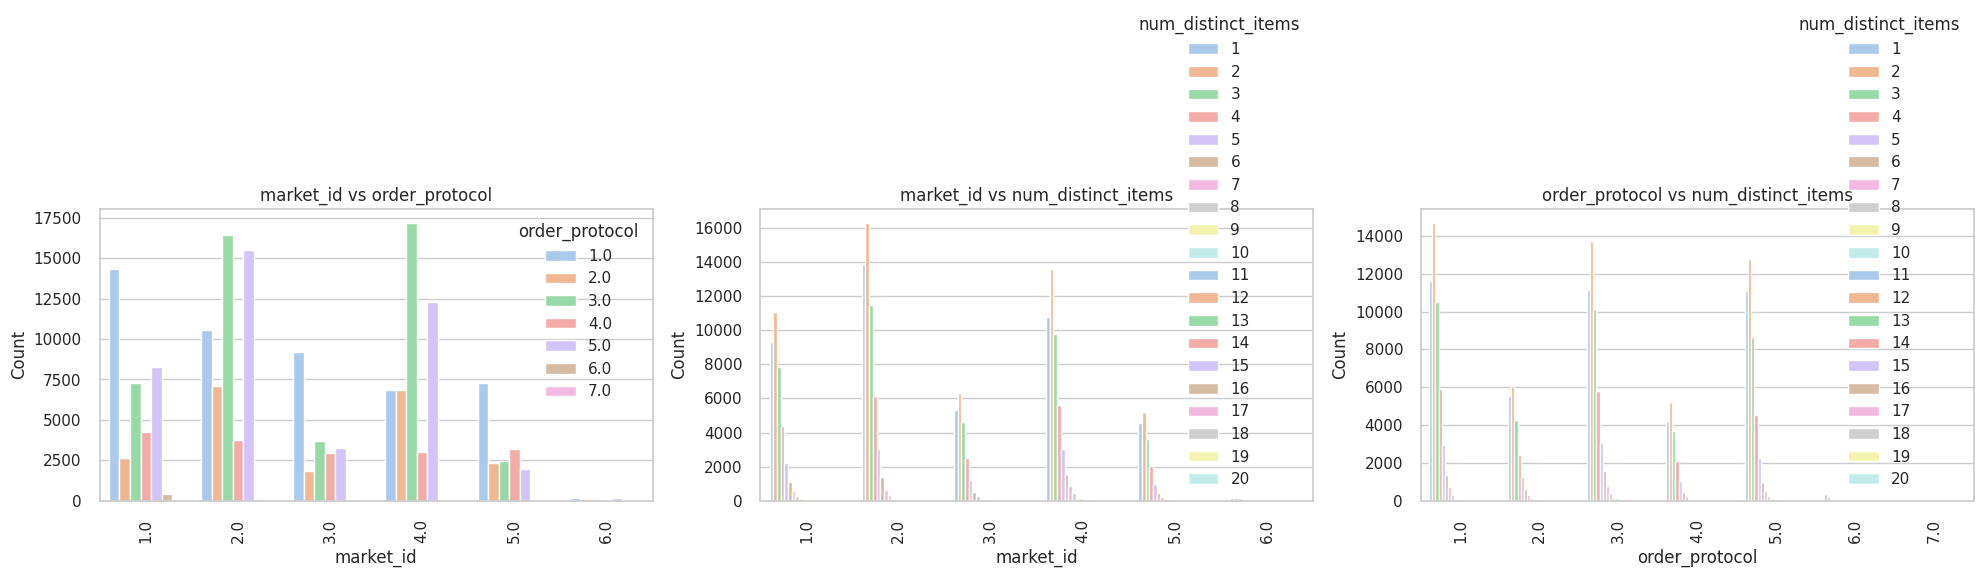

In [30]:
eda_visualizer.bivariate_analysis(
    correlation_threshold=0.5,
    max_categories=29,
    imp_cols_viz=True,   # use only important features if True
    show_violin=False    # boxplots for numeric vs categorical
)



--- Multivariate Analysis ---


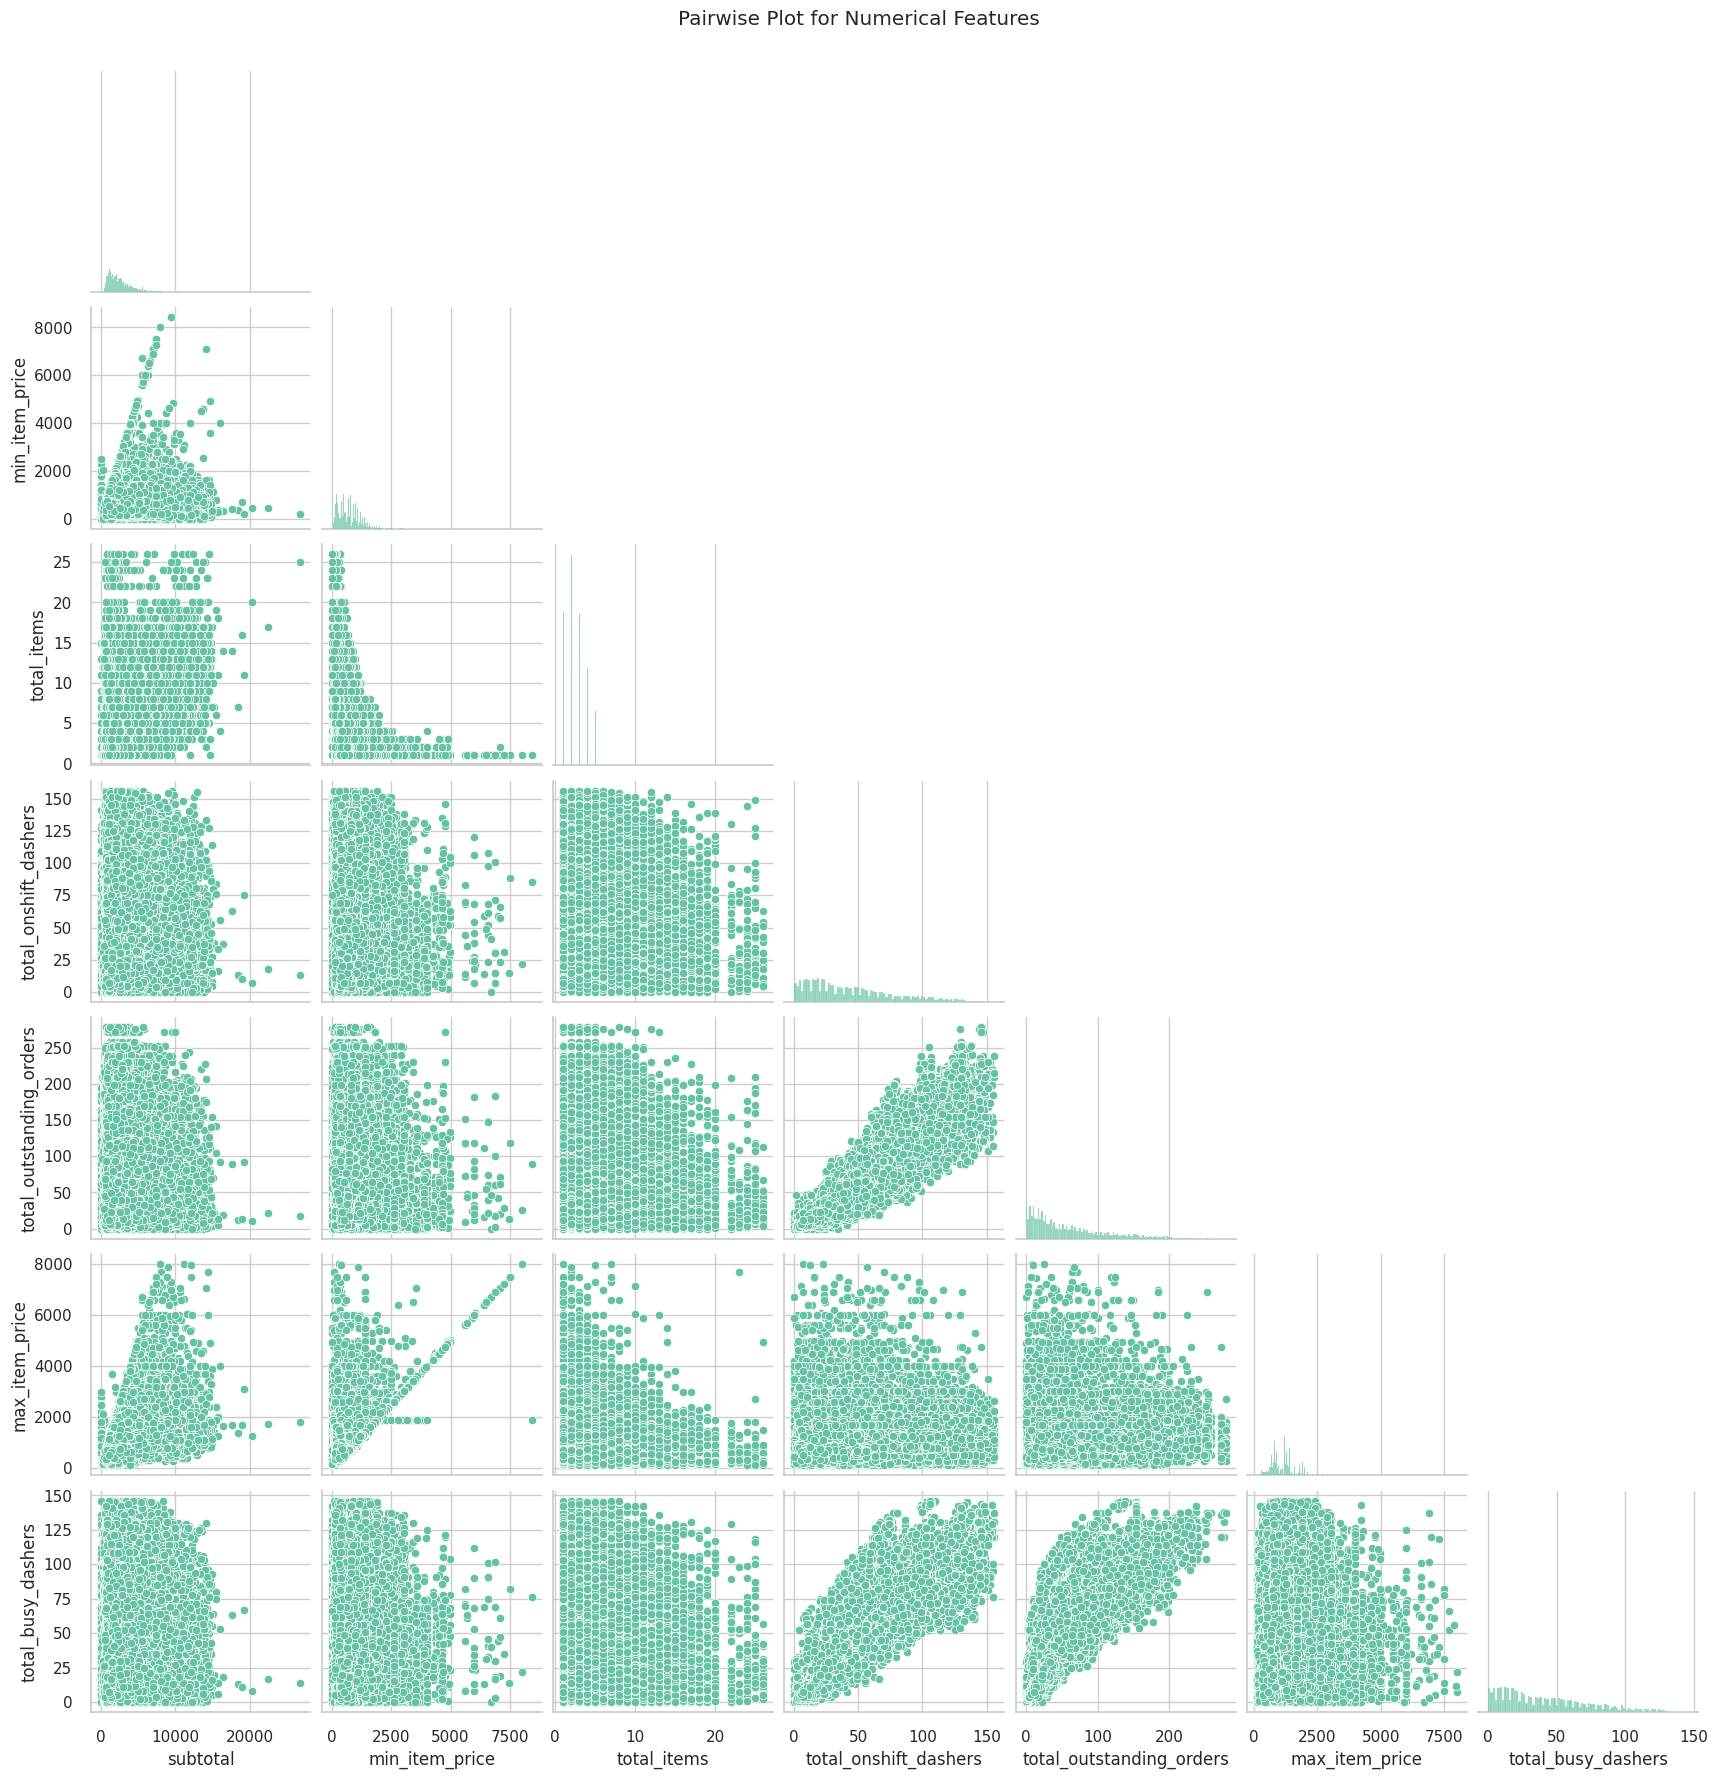

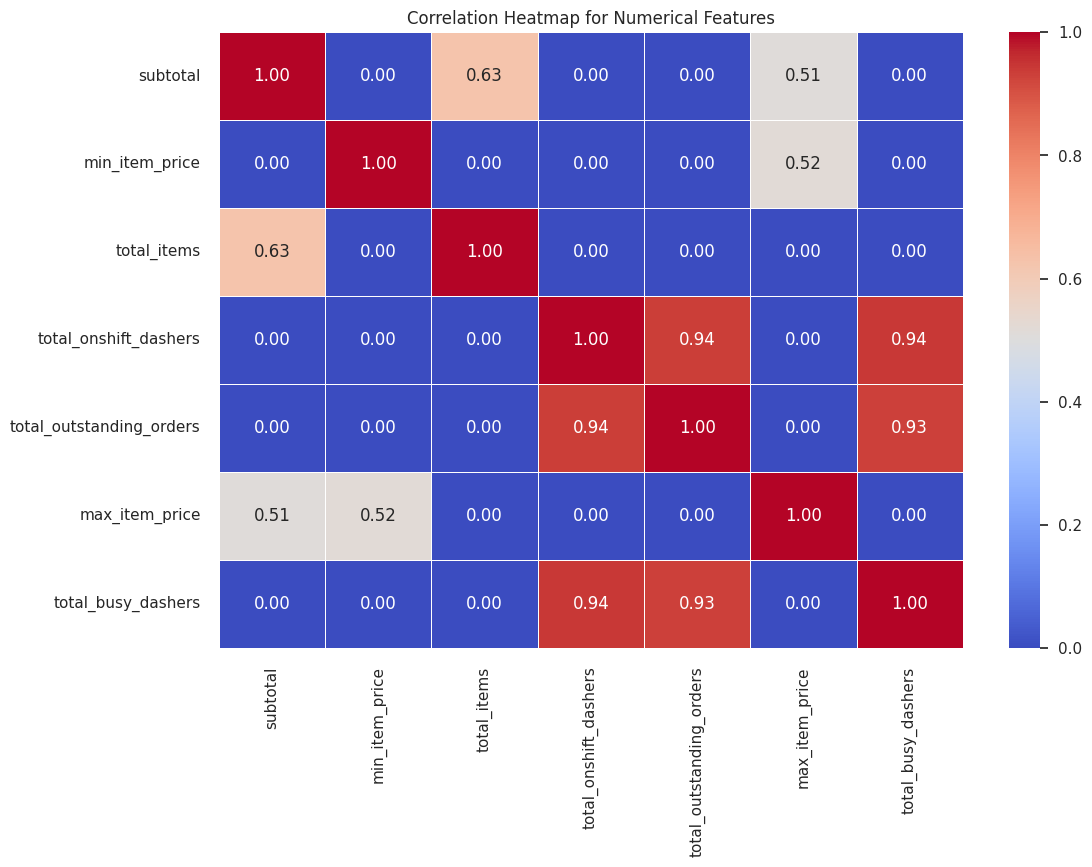

In [31]:
eda_visualizer.multivariate_analysis(
    imp_cols_viz=True,
    correlation_threshold=0.5,
    show_pairplot=True,   # optional pairplot
    show_violin=False     # optional violin plots for numerical vs categorical
)

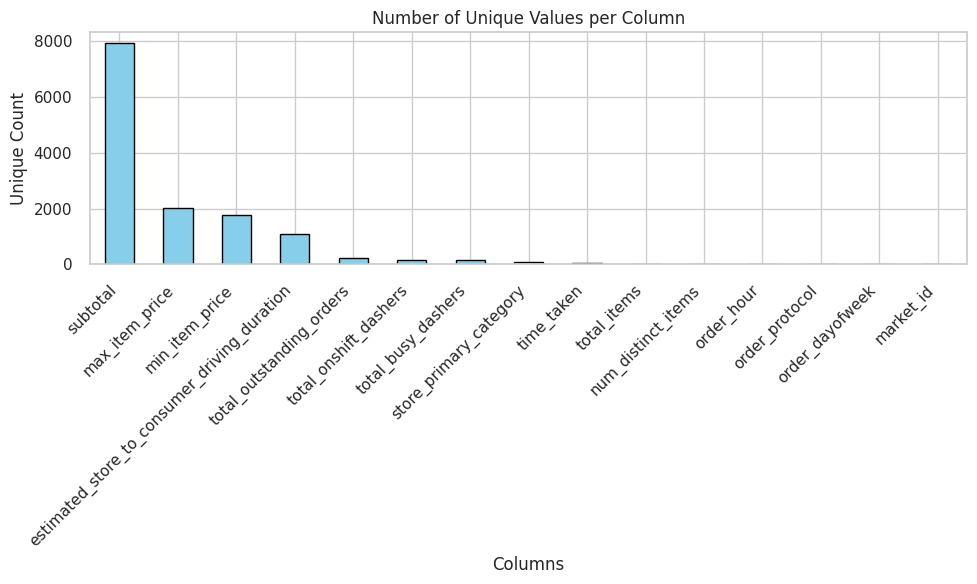

In [32]:
# Compute unique counts
unique_counts = df.nunique().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
unique_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Unique Values per Column')
plt.ylabel('Unique Count')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


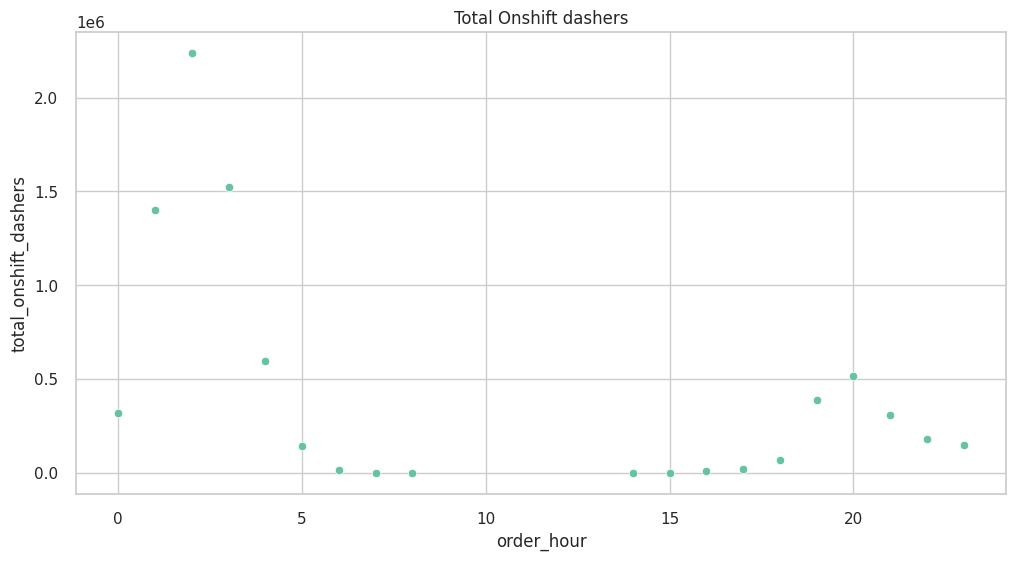

In [33]:
plt.figure(figsize=(12, 6))
plt.title("Total Onshift dashers")
groupdata = df.groupby("order_hour")["total_onshift_dashers"].sum().to_frame()
groupdata.reset_index(inplace=True)
sns.scatterplot(data=groupdata, x="order_hour", y="total_onshift_dashers")
# plt.plot(groupdata)
plt.show()

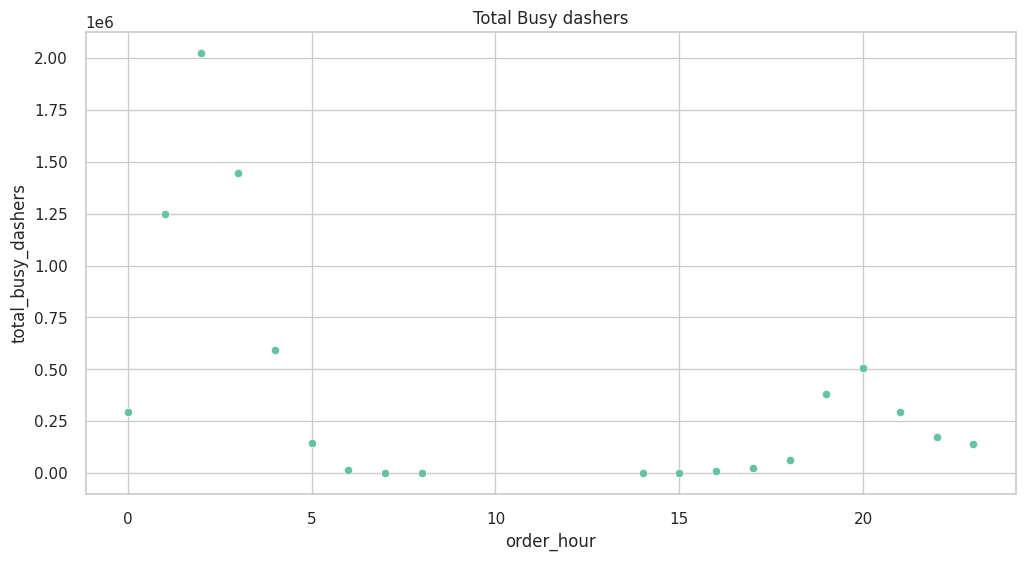

In [34]:
plt.figure(figsize=(12, 6))
plt.title("Total Busy dashers")
groupdata = df.groupby("order_hour")["total_busy_dashers"].sum().to_frame()
groupdata.reset_index(inplace=True)
sns.scatterplot(data=groupdata, x="order_hour", y="total_busy_dashers")
# plt.plot(groupdata)
plt.show()

<Figure size 1200x600 with 0 Axes>

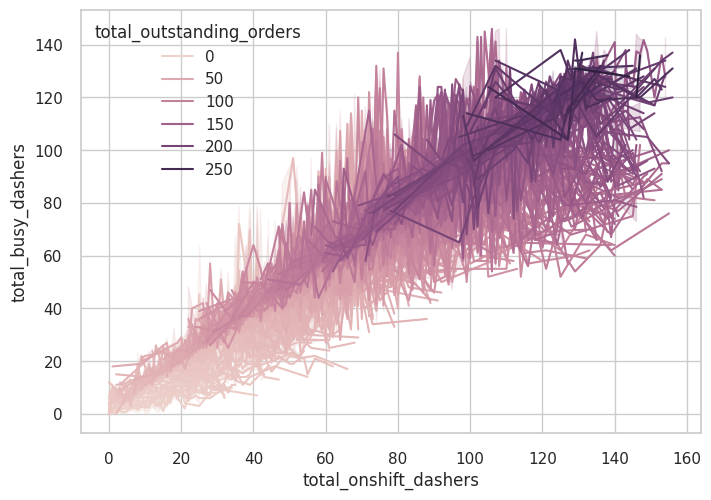

In [35]:
plt.figure(figsize=(12, 6))
plt.show("Multivariate analysis of the data")
sns.lineplot(data=df, x="total_onshift_dashers", y="total_busy_dashers", hue="total_outstanding_orders")
plt.show()

# Key Insights for Data Scientists and Analysts

insights
1. Distribution and Outliers
   - max_item_price is heavily right-skewed with most orders between $500–$2,000 and extreme high-value outliers up to $8,000. The violin plot shows a dense core and long tail, indicating occasional large orders that may warrant log-transformation or capping.
   - Features like subtotal, total_items, and total_outstanding_orders also exhibit heavy tails and numerous outliers, suggesting the need for robust scaling or outlier treatment (e.g., LOF capping) to stabilize model training.

2. Temporal Patterns
   - Both total_onshift_dashers and total_busy_dashers peak in the early morning (1–4 AM) and again around 8–10 PM, with near-zero counts in mid-day hours, indicating two major delivery rush periods. This bimodal pattern can inform time-based features or resource allocation models.

3. Group-Wise Variations
   - total_busy_dashers and total_outstanding_orders vary significantly by market_id, with Market 2 and 4 showing wider distributions and higher medians, implying different demand levels across regions.
   - By order_protocol, Protocol 3 and 5 have higher median busy dashers, while Protocol 7 shows lowest activity, indicating protocol-dependent demand patterns.
   - As num_distinct_items increases, median busy dashers gradually rise, plateauing beyond 10 distinct items, suggesting modest scaling of delivery effort with order complexity.

4. Feature Relationships
   - Very strong positive correlations exist between total_onshift_dashers, total_busy_dashers, and total_outstanding_orders (r≈0.93–0.94), indicating these variables move in tandem and may be redundant in predictive models.
   - Moderate correlation of subtotal with both max_item_price (r≈0.51) and total_items (r≈0.63) suggests order value depends jointly on item count and price, guiding feature engineering for spend prediction.

5. Cardinality and Data Volume
   - subtotal exhibits the highest cardinality (~8,000 unique values), while categorical features like market_id, order_protocol, and num_distinct_items have low to moderate unique counts (6, 7, and 20 respectively), informing encoding strategies (one-hot vs. embedding) and memory considerations.



In [36]:
df['time_taken'].nunique()

55

In [37]:
X = df.drop('time_taken', axis=1)
y = df['time_taken']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [38]:
X_train.head(5)

market_id store_primary_category order_protocol  total_items  subtotal  \
68663        4.0                     38            3.0            1      1895   
119080       4.0                     57            3.0            2      1650   
147983       5.0                      2            3.0            3      2685   
5016         1.0                      4            1.0            2      2400   
129627       4.0                     55            3.0            3      4725   

       num_distinct_items  min_item_price  max_item_price  \
68663                   1            1595            1595   
119080                  2             857             898   
147983                  3             895             895   
5016                    2            1200            1200   
129627                  3            1575            1575   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
68663                    67.0                65.0                      82.0   
119080                   59.0                56.0                     128.0   
147983                   13.0                13.0                      15.0   
5016                     50.0                51.0                      60.0   
129627                   84.0                74.0                     116.0   

        estimated_store_to_consumer_driving_duration  order_hour  \
68663                                          528.0           1   
119080                                         674.0          19   
147983                                         851.0           6   
5016                                           453.0           2   
129627                                         470.0           2   

        order_dayofweek  
68663                 1  
119080                2  
147983                6  
5016                  6  
129627                6


> # Feature Selection



In [39]:
class FeatureSelector:
    def __init__(self, df, target_col, task_type='auto',
                 corr_threshold=0.9, pvalue_threshold=0.05,
                 vif_threshold=5.0, corr_method='pearson',
                 n_bins=5, verbose=True):
        """
        A unified feature selection helper class with correlation, p-values, VIF,
        tree-based feature importance, RFE, regression binning, and visualizations.

        Parameters:
        - df : pandas DataFrame (already cleaned, no NaN)
        - target_col : str
        - task_type : 'auto', 'regression', 'classification'
        - corr_threshold : float
        - pvalue_threshold : float
        - vif_threshold : float
        - corr_method : str
        - n_bins : int, for regression binning
        - verbose : bool
        """
        self.df = df.copy()
        self.target_col = target_col
        self.task_type = task_type
        self.corr_threshold = corr_threshold
        self.pvalue_threshold = pvalue_threshold
        self.vif_threshold = vif_threshold
        self.corr_method = corr_method
        self.n_bins = n_bins
        self.verbose = verbose
        self.to_remove = set()
        self.reasons = {}
        self.feature_importances_ = None
        self.rfe_support_ = None

    # ---------- Utility ----------
    def _infer_task_type(self, y):
        if self.task_type != 'auto':
            return self.task_type
        if pd.api.types.is_integer_dtype(y) or pd.api.types.is_categorical_dtype(y):
            return 'classification'
        return 'regression'

    # ---------- Correlation ----------
    def check_correlation(self):
        num_df = self.df.drop(columns=[self.target_col]).select_dtypes(include='number')
        corr_matrix = num_df.corr(method=self.corr_method)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                corr_val = corr_matrix.iloc[i,j]
                if abs(corr_val) >= self.corr_threshold:
                    high_corr_pairs.append((col1,col2,corr_val))
        return high_corr_pairs, corr_matrix

    # ---------- P-Values ----------
    def check_pvalues(self):
        pvalues = {}
        features = self.df.drop(columns=[self.target_col]).columns
        y = self.df[self.target_col]

        task = self._infer_task_type(y)
        y_bin = None
        if task == 'regression':
            # Bin for categorical tests
            y_bin = pd.qcut(y, q=self.n_bins, duplicates='drop', labels=False)
        else:
            y_bin = y

        for feature in features:
            x = self.df[feature]
            if pd.api.types.is_numeric_dtype(y):
                if pd.api.types.is_numeric_dtype(x):
                    # Pearson correlation + t-test
                    corr = x.corr(y)
                    if not np.isnan(corr):
                        n = len(x)
                        t_stat = corr * np.sqrt((n - 2) / (1 - corr**2))
                        p = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))
                        pvalues[feature] = p
                else:
                    # Categorical feature → ANOVA
                    groups = [y[x == cat] for cat in x.unique()]
                    if len(groups) > 1:
                        _, p = f_oneway(*groups)
                        pvalues[feature] = p
            else:
                # Categorical target
                if pd.api.types.is_numeric_dtype(x):
                    groups = [x[y_bin==val] for val in y_bin.unique()]
                    if len(groups) > 1:
                        _, p = f_oneway(*groups)
                        pvalues[feature] = p
                else:
                    contingency = pd.crosstab(x, y_bin)
                    chi2, p, _, _ = chi2_contingency(contingency)
                    pvalues[feature] = p
        return pvalues

    # ---------- VIF ----------
    def calculate_vif(self):
        num_df = self.df.drop(columns=[self.target_col]).select_dtypes(include='number')
        if num_df.shape[1] < 2:
            return pd.DataFrame(columns=['Feature','VIF'])
        vif_data = pd.DataFrame()
        vif_data['Feature'] = num_df.columns
        vif_data['VIF'] = [variance_inflation_factor(num_df.values, i)
                           for i in range(num_df.shape[1])]
        return vif_data

    def suggest_vif_removals(self):
        vif_df = self.calculate_vif()
        high_vif = vif_df[vif_df['VIF'] > self.vif_threshold]
        for _, row in high_vif.iterrows():
            feat = row['Feature']
            if feat not in self.to_remove:
                self.to_remove.add(feat)
                self.reasons[feat] = f"High VIF ({row['VIF']:.2f})"
        return high_vif

    # ---------- Feature Importance ----------
    def compute_feature_importance(self, n_estimators=100):
        X = self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        task = self._infer_task_type(y)
        if task=='regression':
            model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        else:
            model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        model.fit(X, y)
        importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        self.feature_importances_ = importances
        return importances

    # ---------- RFE ----------
    def compute_rfe(self, n_features_to_select=5):
        X = self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        task = self._infer_task_type(y)
        if task=='regression':
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
        rfe.fit(X, y)
        self.rfe_support_ = pd.Series(rfe.support_, index=X.columns)
        return self.rfe_support_

    # ---------- Main Feature Suggestion ----------
    def suggest_features(self):
        # Correlation
        high_corr, _ = self.check_correlation()
        # P-values
        pvalues = self.check_pvalues()
        # Correlation-based removal
        for col1,col2,corr_val in high_corr:
            p1 = pvalues.get(col1,np.nan)
            p2 = pvalues.get(col2,np.nan)
            if np.isnan(p1) and np.isnan(p2):
                to_drop = col2
            elif np.isnan(p1):
                to_drop = col1
            elif np.isnan(p2):
                to_drop = col2
            else:
                to_drop = col1 if p1>p2 else col2
            if to_drop not in self.to_remove:
                self.to_remove.add(to_drop)
                self.reasons[to_drop] = f"Correlated with {col1 if to_drop==col2 else col2} (r={corr_val:.2f})"
        # P-value based
        for feat, pval in pvalues.items():
            if feat not in self.to_remove and pval>self.pvalue_threshold:
                self.to_remove.add(feat)
                self.reasons[feat] = f"High p-value ({pval:.4f})"
        # VIF
        self.suggest_vif_removals()
        return self.to_remove, self.reasons

    # ---------- Drop features ----------
    def drop_features(self):
        return self.df.drop(columns=list(self.to_remove), errors='ignore')

    # ---------- Summary ----------
    def summary(self):
        if not self.reasons:
            print("✅ No features suggested for removal.")
        else:
            print("⚠️ Suggested Feature Removals:")
            for f,r in self.reasons.items():
                print(f" - {f}: {r}")

    # ---------- Visualization ----------
    def plot_correlation_matrix(self):
        _, corr_matrix = self.check_correlation()
        plt.figure(figsize=(12,10))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title("Correlation Matrix")
        plt.show()

    def plot_vif(self):
        vif_df = self.calculate_vif()
        plt.figure(figsize=(10,6))
        sns.barplot(x='VIF', y='Feature', data=vif_df.sort_values('VIF', ascending=False))
        plt.title("VIF Values")
        plt.show()

    def plot_feature_importance(self, top_n=20):
        if self.feature_importances_ is None:
            self.compute_feature_importance()
        plt.figure(figsize=(10,6))
        self.feature_importances_.head(top_n).sort_values().plot(kind='barh')
        plt.title(f"Top {top_n} Feature Importances")
        plt.show()


In [40]:
# Suppose df is your cleaned dataframe
target_col = 'time_taken'
train_df = X_train.copy()
train_df[target_col] = y_train
fs = FeatureSelector(train_df, target_col=target_col, task_type='auto', verbose=True)

# Feature selection
to_remove, reasons = fs.suggest_features()

# View suggested features and reasons
fs.summary()

⚠️ Suggested Feature Removals:
 - total_busy_dashers: Correlated with total_onshift_dashers (r=0.94)
 - total_outstanding_orders: Correlated with total_onshift_dashers (r=0.94)
 - total_items: High VIF (6.58)
 - subtotal: High VIF (9.90)
 - max_item_price: High VIF (11.13)
 - total_onshift_dashers: High VIF (31.78)
 - estimated_store_to_consumer_driving_duration: High VIF (5.50)




> # Dimensionality Analyzer


In [41]:
class DimensionalityVisualizerAutoSelect:
    def __init__(self, method: str = 'auto', n_components: int = None, random_state: int = 42,
                 perplexity: int = 30, n_iter: int = 1000, n_neighbors: int = 15, min_dist: float = 0.1):
        self.method = method
        self.n_components = n_components
        self.random_state = random_state
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.reducer = None

    # ------------------------------
    # Target type detection
    # ------------------------------
    @staticmethod
    def detect_target_type(y) -> tuple[str, float]:
        y = np.array(y)
        if np.issubdtype(y.dtype, np.number):
            unique_ratio = len(np.unique(y)) / len(y)
            if unique_ratio < 0.05:
                confidence = np.clip(1 - unique_ratio * 10, 0, 1)
                return "classification", round(confidence, 2)
            else:
                confidence = min(1, unique_ratio * 0.8)
                return "regression", round(confidence, 2)
        return "classification", 1.0

    # ------------------------------
    # Method and component selection
    # ------------------------------
    def _select_method(self, X: np.ndarray) -> str:
        if self.method != 'auto':
            return self.method

        n_samples, n_features = X.shape
        if n_samples > 10000:
            return 'pca'
        if n_features > 50:
            return 'umap'
        return 'tsne'

    def _select_components(self, X: np.ndarray) -> int:
        if self.n_components is not None:
            return self.n_components
        return 2 if X.shape[1] > 2 else X.shape[1]

    # ------------------------------
    # Fit
    # ------------------------------
    def fit(self, X: np.ndarray):
        method = self._select_method(X)
        n_comp = self._select_components(X)

        if method == 'pca':
            self.reducer = PCA(n_components=n_comp, random_state=self.random_state)
        elif method == 'tsne':
            self.reducer = TSNE(n_components=n_comp, perplexity=self.perplexity,
                                n_iter=self.n_iter, random_state=self.random_state)
        elif method == 'umap':
            self.reducer = umap.UMAP(n_components=n_comp, n_neighbors=self.n_neighbors,
                                     min_dist=self.min_dist, random_state=self.random_state)
        else:
            raise ValueError(f"Invalid method: {method}")

        self.reducer.fit(X)
        return self

    # ------------------------------
    # Transform
    # ------------------------------
    def transform(self, X: np.ndarray) -> np.ndarray:
        if self.reducer is None:
            raise RuntimeError("Reducer is not fitted yet. Call `fit(X)` first.")
        return self.reducer.transform(X)

    # ------------------------------
    # Fit + Transform (convenience)
    # ------------------------------
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    # ------------------------------
    # Save / Load reducer
    # ------------------------------
    def save(self, filepath: str):
        if self.reducer is None:
            raise RuntimeError("Reducer is not fitted yet. Nothing to save.")
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        joblib.dump({'reducer': self.reducer, 'method': self.method}, filepath)
        print(f"Reducer saved to: {filepath}")

    def load(self, filepath: str):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"No file found at {filepath}")
        data = joblib.load(filepath)
        self.reducer = data['reducer']
        self.method = data.get('method', 'auto')
        print(f"Reducer loaded from: {filepath}")
        return self

    # ------------------------------
    # Plotting helpers
    # ------------------------------
    def _plot_2d(self, X_2d: np.ndarray, labels=None, regression_values=None, title=None):
        plt.figure(figsize=(8, 6))
        if regression_values is not None:
            sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=regression_values,
                             cmap='coolwarm', alpha=0.7, s=40)
            plt.colorbar(sc, label='Target Value')
        elif labels is not None:
            unique_labels = np.unique(labels)
            if len(unique_labels) > 20:
                top_labels = pd.Series(labels).value_counts().nlargest(20).index
                mask = pd.Series(labels).isin(top_labels)
                sns.scatterplot(x=X_2d[mask, 0], y=X_2d[mask, 1],
                                hue=np.array(labels)[mask], palette='tab20', alpha=0.7, s=40)
            else:
                sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels,
                                palette='tab10', alpha=0.7, s=40)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.title(title or "2D Visualization")
        plt.grid(True)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        plt.show()

    def _plot_3d(self, X_3d: np.ndarray, labels=None, regression_values=None, title=None):
        df = pd.DataFrame({'Dim1': X_3d[:, 0], 'Dim2': X_3d[:, 1], 'Dim3': X_3d[:, 2]})
        if labels is not None:
            df['Class'] = labels
        if regression_values is not None:
            df['Regression'] = regression_values

        if regression_values is not None:
            fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3',
                                color='Regression', color_continuous_scale='Viridis',
                                title=title or "3D Regression")
        else:
            fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3',
                                color='Class', title=title or "3D Classification")

        fig.update_layout(scene=dict(
            xaxis_title="Component 1",
            yaxis_title="Component 2",
            zaxis_title="Component 3"
        ))
        fig.show()

    # ------------------------------
    # Main plot interface
    # ------------------------------
    def plot(self, X: np.ndarray, labels=None, regression_values=None, title=None):
        if self.reducer is None:
            X_transformed = self.fit_transform(X)
        else:
            X_transformed = self.transform(X)

        if X_transformed.shape[1] >= 3:
            self._plot_3d(X_transformed, labels=labels, regression_values=regression_values, title=title)
        else:
            self._plot_2d(X_transformed, labels=labels, regression_values=regression_values, title=title)

    # ------------------------------
    # Automatic plot based on y
    # ------------------------------
    def plot_auto(self, X: np.ndarray, y, title=None):
        target_type, confidence = self.detect_target_type(y)
        print(f"🧠 Detected Target Type: {target_type.upper()}  |  Confidence: {confidence * 100:.1f}%")

        if target_type == "classification":
            self.plot(X, labels=y, title=title)
        else:
            self.plot(X, regression_values=y, title=title)


Reduced shape: (123033, 2)
🧠 Detected Target Type: CLASSIFICATION  |  Confidence: 100.0%


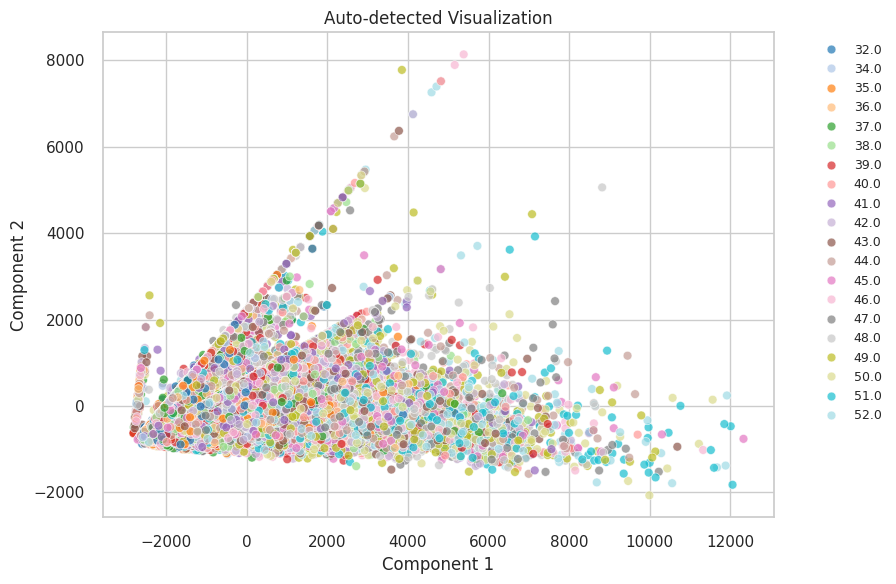

In [42]:
dv = DimensionalityVisualizerAutoSelect(method='auto', random_state=42)
X_reduced = dv.fit_transform(X_train)
print("Reduced shape:", X_reduced.shape)
dv.plot_auto(X_train, y_train, title="Auto-detected Visualization")

The data shows substantial natural clustering and variance along Component 1, which likely aggregates features such as order size, value, or activity—suggesting that a few business metrics dominate customer or transaction differences in this dataset.

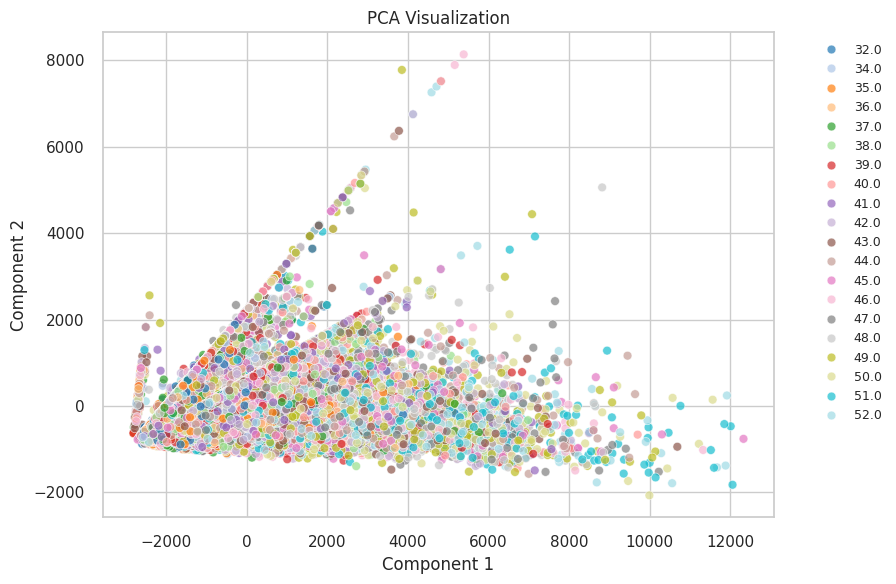

In [43]:
visualizer_pca = DimensionalityVisualizerAutoSelect(method='pca', random_state=42)
X_pca = visualizer_pca.fit_transform(X_train)
visualizer_pca.plot(X_train, labels=y_train, title="PCA Visualization")

In [44]:
visualizer_tsne = DimensionalityVisualizerAutoSelect(method='tsne', random_state=42,
                                                     perplexity=40, n_iter=1000)
X_tsne = visualizer_tsne.fit_transform(X_train)
visualizer_tsne.plot(X_train, labels=y_train, title="t-SNE Visualization")

AttributeError: 'TSNE' object has no attribute 'transform'

In [ ]:
visualizer_umap = DimensionalityVisualizerAutoSelect(method='umap', random_state=42,
                                                     n_neighbors=15, min_dist=0.1)
X_umap = visualizer_umap.fit_transform(X_train)
visualizer_umap.plot(X_train, labels=y_train, title="UMAP Visualization")


> # Skewness Correction



In [ ]:
class SkewnessTransformer:
    def __init__(self, df, skew_threshold=0.5,  winsorize_percentiles=(0.05, 0.95)):
        self.skew_threshold = skew_threshold
        self.transformation_log = {}
        self.yj_transformer = PowerTransformer(method='yeo-johnson')
        self.winsorize_percentiles = winsorize_percentiles
        self.skew_df = None  # Will store the skewness analysis
        self.data_df = df

    def print_skew_values(self):
        skew_values = self.data_df.skew(numeric_only=True)
        print("\n📊 Skewness Values (numeric columns only):\n")
        for col, skew in skew_values.items():
            print(f"  {col:<30} : {skew:.3f}")

    @staticmethod
    def categorize_skew(value):
        if value > 1:
            return 'Highly Right-Skewed'
        elif value > 0.5:
            return 'Moderately Right-Skewed'
        elif value > -0.5:
            return 'Approximately Symmetric'
        elif value > -1:
            return 'Moderately Left-Skewed'
        else:
            return 'Highly Left-Skewed'

    def analyze_skew(self):
        skewness_series = self.data_df.skew(numeric_only=True)
        self.skew_df = skewness_series.reset_index()
        self.skew_df.columns = ['Feature', 'Skewness']
        self.skew_df['Skew Category'] = self.skew_df['Skewness'].apply(self.categorize_skew)
        return self.skew_df

    def plot_skewness(self):
        if self.skew_df is None:
            raise ValueError("Run analyze_skew() before plotting.")

        # Exclude binary columns (<=2 unique values)
        numeric_cols = self.data_df.select_dtypes(include='number')
        non_binary_cols = [col for col in numeric_cols.columns if self.data_df[col].nunique() > 2]
        skew_df_filtered = self.skew_df[self.skew_df['Feature'].isin(non_binary_cols)]

        binary_cols = [col for col in numeric_cols.columns if self.data_df[col].nunique() <= 2]
        print("Skipping binary numeric feature to plot : ", binary_cols , "\n")

        if skew_df_filtered.empty:
            print("⚠️ No non-binary numeric features to plot.")
            return

        plot_df = skew_df_filtered.sort_values(by='Skewness', ascending=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(data=plot_df, x='Skewness', y='Feature', hue='Skew Category', palette='Set2', dodge=False)
        plt.title('Skewness of Numerical Features with Interpretation', fontsize=16, fontweight='bold')
        plt.xlabel('Skewness Value')
        plt.ylabel('Feature')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.legend(title='Skew Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def print_transformation_advice(self, columns):
        for col in columns:
            if self.data_df[col].nunique() <= 2:
                print(f"⚠️ Column '{col}' is binary or categorical. No transformation needed.")
            elif (self.data_df[col] > 0).all():
                print(f"✅ Column '{col}' contains only positive values. Suitable transformations: Box-Cox, Log, or Square Root.")
            elif (self.data_df[col] >= 0).all():
                print(f"⚠️ Column '{col}' contains zero values. Use Log1p or Yeo-Johnson transformation.")
            else:
                print(f"⚠️ Column '{col}' contains negative values. Use Yeo-Johnson or Winsorization transformation.")


    def choose_transformation(self, skew, min_val):
        if abs(skew) <= self.skew_threshold:
            return 'none'
        elif min_val > 0:
            if skew > 1:
                return 'log'
            elif skew > 0.5:
                return 'sqrt'
            else:
                return 'boxcox'
        elif min_val == 0:
            return 'log1p'
        else:
          if abs(skew) > 1:
            return 'yeojohnson'  # Highly skewed with negative values: Yeo-Johnson transformation
          else:
            return 'winsorize'  # Moderate skew with negative values: apply Winsorization



    def transform(self):
        df = self.data_df.copy()  # Avoid modifying original
        for col in df.select_dtypes(include='number').columns:
            if df[col].nunique() <= 2:
                self.transformation_log[col] = 'binary - skipped'
                continue

            skew = df[col].skew()
            min_val = df[col].min()
            method = self.choose_transformation(skew, min_val)

            try:
                if method == 'winsorize':
                    lower_percentile, upper_percentile = self.winsorize_percentiles
                    df[col + '_winsorized'] = winsorize(df[col], limits=(lower_percentile, upper_percentile))
                elif method == 'log':
                    df[col + '_log'] = np.log(df[col])
                elif method == 'sqrt':
                    df[col + '_sqrt'] = np.sqrt(df[col])
                elif method == 'log1p':
                    df[col + '_log1p'] = np.log1p(df[col])
                elif method == 'boxcox':
                    transformed, _ = boxcox(df[col])
                    df[col + '_boxcox'] = transformed
                elif method == 'yeojohnson':
                    df[col + '_yj'] = self.yj_transformer.fit_transform(df[[col]])
                self.transformation_log[col] = method
            except Exception as e:
                self.transformation_log[col] = f'error: {e}'

        return df

    def apply_manual_transformation(self, column, method):
        """
        Manually apply a specific transformation to a given column.

        Parameters:
            column (str): Name of the column to transform.
            method (str): One of ['log', 'sqrt', 'log1p', 'boxcox', 'yeojohnson', 'winsorize'].

        Returns:
            pd.Series: Transformed column (also adds it to self.data_df).
        """
        df = self.data_df  # work directly on internal df

        if column not in df.columns:
            print(f"❌ Column '{column}' not found.")
            return None

        if df[column].nunique() <= 2:
            print(f"⚠️ Column '{column}' is binary or categorical. No transformation applied.")
            return None

        try:
            if method == 'winsorize':
                lower_percentile, upper_percentile = self.winsorize_percentiles
                transformed = winsorize(df[column], limits=(lower_percentile, upper_percentile))
                new_col = f"{column}_winsorized"
            elif method == 'log':
                transformed = np.log(df[column])
                new_col = f"{column}_log"
            elif method == 'sqrt':
                transformed = np.sqrt(df[column])
                new_col = f"{column}_sqrt"
            elif method == 'log1p':
                transformed = np.log1p(df[column])
                new_col = f"{column}_log1p"
            elif method == 'boxcox':
                transformed, _ = boxcox(df[column])
                new_col = f"{column}_boxcox"
            elif method == 'yeojohnson':
                transformed = self.yj_transformer.fit_transform(df[[column]])
                new_col = f"{column}_yj"
            else:
                print(f"❌ Unknown transformation method: {method}")
                return None

            # Save transformed column
            df[new_col] = transformed
            self.transformation_log[column] = f'manual: {method}'
            print(f"✅ Applied '{method}' transformation to '{column}', new column: '{new_col}'")
            return df[new_col]

        except Exception as e:
            print(f"❌ Error transforming '{column}' with '{method}': {e}")
            self.transformation_log[column] = f'manual-error: {method} -> {e}'
            return None

    def summary(self):
        return pd.DataFrame(list(self.transformation_log.items()), columns=['Feature', 'Transformation'])


In [ ]:
# For all numerical columns
X_train_transformer = SkewnessTransformer(X_train, winsorize_percentiles=(0.01, 0.25))
X_train_transformer.print_skew_values()

In [ ]:
# For all numerical columns
X_test_transformer = SkewnessTransformer(X_test, winsorize_percentiles=(0.01, 0.25))
X_test_transformer.print_skew_values()

In [ ]:
X_train_transformer.analyze_skew()
X_train_transformer.plot_skewness()

In [ ]:
X_test_transformer.analyze_skew()
X_test_transformer.plot_skewness()



**Observations:**

1. **High Skewness in Few Columns:**  
   - `total_items`, `subtotal`, `min_item_price`, and `max_item_price` show skewness values above **2.0**, indicating right-skewed distributions.  
   - These variables may benefit from transformations such as **Yeo–Johnson** or **log transformation** to stabilize variance.

2. **Moderate Skewness:**  
   - Columns like `total_onshift_dashers`, `total_busy_dashers`, and `total_outstanding_orders` exhibit moderate skewness (~0.7–1.1).  
   - These values are acceptable but could still impact model performance slightly, especially for models sensitive to non-normal data (e.g., linear models).

3. **Nearly Symmetric Columns:**  
   - `order_hour`, `order_dayofweek`, and `estimated_store_to_consumer_driving_duration` show near-zero skewness (|skew| < 0.2).  
   - These distributions are approximately symmetric and likely don’t need transformation.

4. **Consistency Between Train and Test:**  
   - Skewness values are **consistent across X_train and X_test**, which confirms that both datasets are similarly distributed.  
   - This consistency reduces the risk of data drift and ensures the transformations applied on the training data will generalize well.

**Conclusion:**  
Focus on reducing skewness for the **item- and price-related features** to improve model stability and predictive accuracy.


In [ ]:
columns = [
    'order_hour', 'total_busy_dashers', 'total_onshift_dashers',
    'total_outstanding_orders', 'subtotal', 'max_item_price', 'min_item_price', 'total_items'
]
X_train_transformer.print_transformation_advice(columns)

In [ ]:
X_test_transformer.print_transformation_advice(columns)

In [ ]:
X_train_transformed = X_train_transformer.transform()
# View transformation summary
X_train_transformer.summary()

In [ ]:
X_test_transformed = X_test_transformer.transform()
# View transformation summary
X_test_transformer.summary()

In [ ]:
X_train_transformed.head(5).T

In [ ]:
X_test_transformed.head(5)

In [ ]:
y_train.head(5)

In [ ]:
y_train.unique()

In [ ]:
y_test.head(5)

In [ ]:
X_train_transformer = SkewnessTransformer(X_train_transformed)
X_train_transformer.print_skew_values()

In [ ]:
X_test_transformer = SkewnessTransformer(X_test_transformed)
X_test_transformer.print_skew_values()

In [ ]:
X_train_transformer.analyze_skew()
X_train_transformer.plot_skewness()

In [ ]:
X_test_transformer.analyze_skew()
X_test_transformer.plot_skewness()

In [ ]:
# Inspect transformed train set
print(X_train_transformed.shape)
print(X_train_transformed.dtypes)

In [ ]:
# Inspect transformed train set
print(X_test_transformed.shape)
print(X_test_transformed.dtypes)



> # Encoding


In [ ]:
class CategoricalEncoder:
    def __init__(self, encoding_map=None, default_encoding='onehot', verbose=True):
        """
        :param encoding_map: dict | Mapping of column -> encoding method
                             Example: {'gender': 'onehot', 'city': 'frequency', 'user_id': 'skip'}
        :param default_encoding: Default encoding method if column not in encoding_map
        :param verbose: Print detailed logs
        """
        self.encoding_map = encoding_map or {}
        self.default_encoding = default_encoding
        self.verbose = verbose
        self.encoders = {}
        self.y_encoder = None  # for encoding target variable if categorical

    # -------------------- INDIVIDUAL ENCODERS -------------------- #
    def _one_hot(self, df, cols):
        return pd.get_dummies(df, columns=cols, drop_first=True)

    def _ordinal(self, df, cols, fit=True):
        if fit:
            enc = OrdinalEncoder()
            df[cols] = enc.fit_transform(df[cols])
            self.encoders['ordinal'] = enc
        else:
            enc = self.encoders.get('ordinal')
            df[cols] = enc.transform(df[cols])
        return df

    def _target(self, df, cols, target, fit=True):
        if fit:
            enc = ce.TargetEncoder(cols=cols)
            df[cols] = enc.fit_transform(df[cols], df[target])
            self.encoders['target'] = enc
        else:
            enc = self.encoders.get('target')
            df[cols] = enc.transform(df[cols])
        return df

    def _frequency(self, df, cols, fit=True):
        for col in cols:
            if fit:
                freq_map = df[col].value_counts() / len(df)
                self.encoders[f'freq_{col}'] = freq_map
            df[col] = df[col].map(self.encoders[f'freq_{col}']).fillna(0)
        return df

    def _binary(self, df, cols, fit=True):
        if fit:
            enc = ce.BinaryEncoder(cols=cols)
            df = enc.fit_transform(df)
            self.encoders['binary'] = enc
        else:
            enc = self.encoders.get('binary')
            df = enc.transform(df)
        return df

    def _hash(self, df, cols, n_components=5, fit=True):
        if fit:
            enc = ce.HashingEncoder(cols=cols, n_components=n_components)
            df = enc.fit_transform(df)
            self.encoders['hash'] = enc
        else:
            enc = self.encoders.get('hash')
            df = enc.transform(df)
        return df

    # -------------------- CORE APPLY FUNCTION -------------------- #
    def _apply_encoding(self, df, cols, target=None, fit=True):
        for col in cols:
            method = self.encoding_map.get(col, self.default_encoding)

            # Skip columns
            if method == 'skip':
                if self.verbose:
                    print(f"⚙️ Skipping encoding for column: '{col}'")
                continue

            if self.verbose:
                print(f"➡️ Encoding column: '{col}' using [{method}]")

            if method == 'onehot':
                df = self._one_hot(df, [col])
            elif method == 'ordinal':
                df = self._ordinal(df, [col], fit)
            elif method == 'target':
                if target is None:
                    raise ValueError("Target column must be provided for target encoding.")
                df = self._target(df, [col], target, fit)
            elif method == 'frequency':
                df = self._frequency(df, [col], fit)
            elif method == 'binary':
                df = self._binary(df, [col], fit)
            elif method == 'hash':
                df = self._hash(df, [col], fit)
            else:
                raise ValueError(f"Unsupported encoding method: {method}")
        return df

    # -------------------- TARGET ENCODING -------------------- #

    def _encode_target(self, y, fit=True):
        """
        Encode y_train and y_test if categorical (object/string or integer class labels).
        Returns a pandas Series with the same name and index as y.
        """
        if y is None:
            return y

        # Ensure y is a pandas Series
        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        name = y.name

        # Determine if we should encode: object, category, or integer dtype
        if pd.api.types.is_object_dtype(y.dtype) \
          or pd.api.types.is_categorical_dtype(y.dtype) \
          or (pd.api.types.is_integer_dtype(y.dtype) and y.nunique() < len(y) / 2) \
           or (pd.api.types.is_float_dtype(y.dtype) and y.nunique() < len(y) / 2):
            # Fit phase
            if fit:
                if self.verbose:
                    print("🎯 Fitting and encoding target variable with LabelEncoder")
                self.y_encoder = LabelEncoder()
                y_enc = self.y_encoder.fit_transform(y)
            else:
                if self.y_encoder is None:
                    raise RuntimeError("LabelEncoder has not been fitted yet. Call fit() first.")
                if self.verbose:
                    print("🎯 Transforming target variable with existing LabelEncoder")
                y_enc = self.y_encoder.transform(y)

            # Return as Series
            return pd.Series(y_enc, index=y.index, name=name)

        # Numeric continuous target: return unchanged
        return y


    # -------------------- PUBLIC METHODS -------------------- #
    def fit_transform(self, X_train, y_train=None, target_col=None):
        """Fit on training data and transform it."""
        X_train_encoded = X_train.copy()
        if target_col is not None and y_train is not None:
            X_train_encoded[target_col] = y_train
        X_train_encoded = self._apply_encoding(X_train_encoded, X_train.columns, target_col, fit=True)
        if target_col in X_train_encoded.columns:
            X_train_encoded.drop(columns=[target_col], inplace=True)
        y_train_encoded = self._encode_target(y_train, fit=True)
        return X_train_encoded, y_train_encoded

    def transform(self, X_test, y_test=None, target_col=None):
        """Transform test data using encoders fitted on training data."""
        X_test_encoded = X_test.copy()
        if target_col is not None and y_test is not None:
            X_test_encoded[target_col] = y_test
        X_test_encoded = self._apply_encoding(X_test_encoded, X_test.columns, target_col, fit=False)
        if target_col in X_test_encoded.columns:
            X_test_encoded.drop(columns=[target_col], inplace=True)
        y_test_encoded = self._encode_target(y_test, fit=False)
        return X_test_encoded, y_test_encoded

    def fit_transform_all(self, X_train, X_test, y_train=None, y_test=None, target_col=None):
        """Fit on train → transform both train and test, returning all four sets."""
        X_train_enc, y_train_enc = self.fit_transform(X_train, y_train, target_col)
        X_test_enc, y_test_enc = self.transform(X_test, y_test, target_col)
        return X_train_enc, X_test_enc, y_train_enc, y_test_enc


In [ ]:
encoding_map = {
    'store_primary_category': 'skip',
    'market_id': 'skip',
    'order_protocol': 'skip',
    'num_distinct_items': 'skip'
}

encoder = CategoricalEncoder(encoding_map=encoding_map, default_encoding='skip', verbose=True)

X_train_enc, X_test_enc, y_train_enc, y_test_enc = encoder.fit_transform_all(
    X_train_transformed, X_test_transformed,
    y_train=y_train,
    y_test=y_test,
    target_col='time_taken'  # only needed for TargetEncoder
)


# Initialize the encoder (you can skip all features for now if only encoding target)
encoder = CategoricalEncoder(encoding_map={}, default_encoding='skip', verbose=True)

# Encode target variable y_train and y_test
y_train_enc = encoder._encode_target(y_train, fit=True)   # Fit and transform on training target
y_test_enc = encoder._encode_target(y_test, fit=False)    # Transform test target using the same encoder



In [ ]:
categorical_cols = [
    'market_id',
    'store_primary_category',
    'order_protocol',
    'num_distinct_items'
]

for col in categorical_cols:
    uniques = sorted(X_train[col].unique())
    print(f"{col} ({len(uniques)} unique): {uniques}")

In [ ]:
uniques = sorted(y_train_enc.unique())
print(f"{col} ({len(uniques)} unique): {uniques}")

In [ ]:
uniques = sorted(y_test_enc.unique())
print(f"{col} ({len(uniques)} unique): {uniques}")

In [ ]:
X_train_transformed.equals(X_train_enc)

In [ ]:
X_test_transformed.equals(X_test_enc)

In [ ]:
y_train.equals(y_train_enc)

In [ ]:
y_test.equals(y_test_enc)



> # Scaling



In [ ]:
class DataPreprocessor:
    def __init__(self, scaling_method='standard', handle_outliers=False, is_sparse=False, scale_target=False):
        """
        Initialize the DataPreprocessor class.

        :param scaling_method: 'standard', 'minmax', 'robust', 'maxabs' - method for scaling features.
        :param handle_outliers: Boolean, if True, applies Robust Scaling for outlier handling.
        :param is_sparse: Boolean, if True, applies MaxAbs Scaling for sparse data.
        :param scale_target: Boolean, if True, scales target variable (useful for regression).
        """
        self.scaling_method = scaling_method
        self.handle_outliers = handle_outliers
        self.is_sparse = is_sparse
        self.scale_target = scale_target
        self.scaler_X = None
        self.scaler_y = None  # For target scaling

    def scale_data(self, X, is_test_data=False):
        """Scale feature data based on provided criteria."""
        mode = "test" if is_test_data else "training"
        if self.scaling_method == 'standard':
            if not is_test_data:
                self.scaler_X = StandardScaler()
                X_scaled = self.scaler_X.fit_transform(X)
            else:
                X_scaled = self.scaler_X.transform(X)
        elif self.scaling_method == 'minmax':
            if not is_test_data:
                self.scaler_X = MinMaxScaler()
                X_scaled = self.scaler_X.fit_transform(X)
            else:
                X_scaled = self.scaler_X.transform(X)
        elif self.scaling_method == 'robust' or self.handle_outliers:
            if not is_test_data:
                self.scaler_X = RobustScaler()
                X_scaled = self.scaler_X.fit_transform(X)
            else:
                X_scaled = self.scaler_X.transform(X)
        elif self.scaling_method == 'maxabs' or self.is_sparse:
            if not is_test_data:
                self.scaler_X = MaxAbsScaler()
                X_scaled = self.scaler_X.fit_transform(X)
            else:
                X_scaled = self.scaler_X.transform(X)
        else:
            raise ValueError("Invalid scaling method. Choose from ['standard', 'minmax', 'robust', 'maxabs']")

        return X_scaled

    def scale_target_variable(self, y, is_test_data=False):
        """Optionally scale target variable for regression tasks."""
        if not self.scale_target:
            return y

        if y.ndim == 1:
            y = y.reshape(-1, 1)

        if not is_test_data:
            self.scaler_y = StandardScaler()
            y_scaled = self.scaler_y.fit_transform(y)
        else:
            y_scaled = self.scaler_y.transform(y)
        return y_scaled

    def preprocess(self, X, y=None, is_test_data=False):
        """Preprocess features (and optionally target)."""
        X_scaled = self.scale_data(X, is_test_data)
        if y is not None:
            y_scaled = self.scale_target_variable(y, is_test_data)
        else:
            y_scaled = y
        return X_scaled, y_scaled


In [ ]:
# Initialize DataPreprocessor with target scaling
preprocessor = DataPreprocessor(scaling_method='standard', scale_target=False)

# Preprocess training data
X_train_scaled, y_train = preprocessor.preprocess(X_train_enc, y_train_enc, is_test_data=False)
X_test_scaled, y_test = preprocessor.preprocess(X_test_enc, y_test_enc, is_test_data=True)


# → Reason: Scalers like StandardScaler, MinMaxScaler work only on features (X), not on labels (y).
# → Scaling y is only considered in regression tasks (not classification).

In [ ]:
X_train.nunique()


In [ ]:
X_train.dtypes



> # ImBalance Handler



In [ ]:
class ImbalanceHandler:
    def __init__(
        self,
        target_col,
        task_type='auto',  # 'classification' or 'regression'
        imbalance_threshold=0.2,
        strategy="auto",
        sampling_strategy="auto",
        random_state=42,
        use_smote=True,
        use_adasyn=False,
        n_bins=5,          # For regression: number of bins to detect imbalance
        verbose=True,
    ):
        """
        Handles imbalanced datasets for classification and regression.

        Parameters:
          target_col (str): Name of the target column.
          task_type (str): 'classification', 'regression', or 'auto' (infer from dtype).
          imbalance_threshold (float): Ratio threshold to flag imbalance (0–1).
          strategy (str): 'over', 'under', or 'auto'.
          sampling_strategy (str or dict): Passed to sampler ('auto' recommended).
          random_state (int): Random seed.
          use_smote (bool): Use SMOTE (numeric features only) for classification.
          use_adasyn (bool): Use ADASYN (numeric features only) for classification.
          n_bins (int): Number of bins for regression imbalance detection.
          verbose (bool): Whether to print logs.
        """
        self.target_col = target_col
        self.task_type = task_type
        self.imbalance_threshold = imbalance_threshold
        self.strategy = strategy
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.use_smote = use_smote
        self.use_adasyn = use_adasyn
        self.n_bins = n_bins
        self.verbose = verbose

    # ---------- Utility Methods ----------
    def get_class_distribution(self, y):
        counts = Counter(y)
        total = sum(counts.values())
        dist = pd.DataFrame({
            "Class": list(counts.keys()),
            "Count": list(counts.values()),
            "Percent": [round(c / total * 100, 2) for c in counts.values()],
        }).sort_values(by="Percent", ascending=False)
        return dist.reset_index(drop=True)

    def _infer_task_type(self, y):
        if self.task_type != 'auto':
            return self.task_type
        # Simple heuristic: integer/categorical → classification, else regression
        if pd.api.types.is_integer_dtype(y) or pd.api.types.is_categorical_dtype(y):
            return 'classification'
        return 'regression'

    def detect_imbalance(self, y):
        task = self._infer_task_type(y)

        if task == 'classification':
            counts = Counter(y)
            fractions = np.array(list(counts.values())) / sum(counts.values())
            imbalance_ratio = fractions.min() / fractions.max()
            is_imbalanced = imbalance_ratio < self.imbalance_threshold

        else:  # regression
            # Bin the target
            y_binned = pd.qcut(y, q=self.n_bins, duplicates='drop', labels=False)
            counts = Counter(y_binned)
            fractions = np.array(list(counts.values())) / sum(counts.values())
            imbalance_ratio = fractions.min() / fractions.max()
            is_imbalanced = imbalance_ratio < self.imbalance_threshold
            y = y_binned  # For reporting only

        if self.verbose:
            print("\nClass / Bin distribution:")
            print(pd.DataFrame({
                "Class/Bin": list(counts.keys()),
                "Fraction": [round(f,4) for f in fractions]
            }))
            print(f"→ Imbalance Ratio (min/max): {imbalance_ratio:.3f}")
            print(f"→ Is Imbalanced? {'Yes' if is_imbalanced else 'No'}")

        return is_imbalanced, imbalance_ratio

    def _choose_sampler(self, imbalance_ratio, X):
        sampler, method = None, "None"

        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
        smotenc_possible = len(categorical_cols) > 0 and len(numeric_cols) > 0

        # Over-sampling
        if self.strategy == "over" or (self.strategy == "auto" and imbalance_ratio < 0.5):
            if smotenc_possible:
                sampler = SMOTENC(
                    categorical_features=[X.columns.get_loc(c) for c in categorical_cols],
                    sampling_strategy=self.sampling_strategy,
                    random_state=self.random_state
                )
                method = "SMOTENC"
            elif self.use_adasyn and len(numeric_cols) == X.shape[1]:
                sampler = ADASYN(sampling_strategy=self.sampling_strategy,
                                 random_state=self.random_state)
                method = "ADASYN"
            elif self.use_smote and len(numeric_cols) == X.shape[1]:
                sampler = SMOTE(sampling_strategy=self.sampling_strategy,
                                random_state=self.random_state)
                method = "SMOTE"
            else:
                sampler = RandomOverSampler(sampling_strategy=self.sampling_strategy,
                                            random_state=self.random_state)
                method = "RandomOverSampler"

        # Under-sampling
        elif self.strategy == "under" or (self.strategy == "auto" and imbalance_ratio >= 0.5):
            sampler = RandomUnderSampler(sampling_strategy=self.sampling_strategy,
                                         random_state=self.random_state)
            method = "RandomUnderSampler"

        return sampler, method

    # ---------- Core Method ----------
    def balance_data(self, X, y):
        task = self._infer_task_type(y)
        is_imbalanced, imbalance_ratio = self.detect_imbalance(y)

        if not is_imbalanced:
            if self.verbose:
                print("✅ Data is already balanced. No sampling applied.")
            return X, y

        if task == 'regression':
            # For regression, bin y and oversample rare bins using RandomOverSampler
            y_binned = pd.qcut(y, q=self.n_bins, duplicates='drop', labels=False)
            sampler = RandomOverSampler(sampling_strategy=self.sampling_strategy,
                                        random_state=self.random_state)
            X_res, y_binned_res = sampler.fit_resample(X, y_binned)
            # Map oversampled bins back to original y range by sampling values within bin
            y_res = []
            bin_to_values = {bin_: y[y_binned==bin_].values for bin_ in np.unique(y_binned)}
            for bin_ in y_binned_res:
                y_res.append(np.random.choice(bin_to_values[bin_]))
            y_res = np.array(y_res)
            if self.verbose:
                print(f"✅ Regression data balanced using RandomOverSampler on bins.")
            return X_res, y_res

        else:
            # Classification: use existing logic
            sampler, method = self._choose_sampler(imbalance_ratio, X)
            if sampler is None:
                if self.verbose:
                    print("⚠️ No valid sampler found; returning original dataset.")
                return X, y

            if self.verbose:
                print(f"\n⚙️ Applying {method}...")

            try:
                X_res, y_res = sampler.fit_resample(X, y)
            except ValueError as e:
                if self.verbose:
                    print(f"⚠️ Sampler failed: {e}\nFalling back to RandomOverSampler.")
                sampler = RandomOverSampler(sampling_strategy=self.sampling_strategy,
                                            random_state=self.random_state)
                X_res, y_res = sampler.fit_resample(X, y)
                method = "RandomOverSampler (fallback)"

            if self.verbose:
                print(f"✅ Balancing complete using {method}.")
                print(self.get_class_distribution(y_res))

            return X_res, y_res


In [ ]:
handler = ImbalanceHandler(
    target_col='time_taken',
    task_type='classification',
    imbalance_threshold=0.2,
    strategy='auto',
    verbose=True
)

# Check imbalance on training target
is_imbalanced, imbalance_ratio = handler.detect_imbalance(y_train_enc)

print(f"\nIs data imbalanced? {'Yes' if is_imbalanced else 'No'}")
print(f"Imbalance ratio (min/max class fraction): {imbalance_ratio:.3f}")


In [ ]:
# Get class distribution
class_dist = handler.get_class_distribution(y_train_enc)
print(class_dist)

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_enc.columns, index=X_train_enc.index)
X_train_bal, y_train_bal = handler.balance_data(X_train_scaled_df, y_train_enc)

In [ ]:
y_train_bal.value_counts(normalize=True)

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(y_train_bal, kde=True, bins=30)
plt.title("Distribution of Target: time_taken")
plt.xlabel("time_taken")
plt.ylabel("Frequency")
plt.show()


The target variable time_taken shows a nearly uniform distribution across its range, with each interval containing similar frequencies and no visible skew. This suggests the data has been either binned or synthetically balanced, resulting in no dominant mode or clustering—an ideal scenario for many regression and ML tasks as it avoids bias toward any particular value range.



> # Train Random Forest Model



In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train_bal, y_train_bal)

In [ ]:
prediction = classifier.predict(X_test_scaled)
probs = classifier.predict_proba(X_test_scaled)

In [ ]:
class RandomForestEvaluator:
    def __init__(self, model, task_type='regression', verbose=True):
        self.model = model
        self.task_type = task_type
        self.verbose = verbose

    # ---------- Regression Metrics ----------
    def _regression_metrics(self, y_true, y_pred):
        metrics = {
            "MSE": mean_squared_error(y_true, y_pred),
            "RMSE": mean_squared_error(y_true, y_pred),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R2": r2_score(y_true, y_pred)
        }
        return metrics

    # ---------- Classification Metrics ----------
    def _classification_metrics(self, y_true, y_pred, y_prob=None):
        metrics = {
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1_macro": f1_score(y_true, y_pred, average='macro'),
            "F1_weighted": f1_score(y_true, y_pred, average='weighted'),
            "ConfusionMatrix": confusion_matrix(y_true, y_pred)
        }

        # Binary or multi-class AUC
        if y_prob is not None:
            if len(np.unique(y_true)) == 2:
                metrics["AUC"] = roc_auc_score(y_true, y_prob)
            else:
                y_bin = label_binarize(y_true, classes=np.unique(y_true))
                metrics["AUC"] = roc_auc_score(y_bin, y_prob, multi_class='ovr')

        return metrics

    # ---------- Plots ----------
    def _plot_residuals(self, X_train, y_train, X_test, y_test):
        visualizer = ResidualsPlot(self.model, hist=False, qqplot=True)
        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        visualizer.show()

    def _plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def _plot_roc_curve(self, y_true, y_prob, top_n=10):
        plt.figure(figsize=(7, 6))
        classes = np.unique(y_true)
        y_bin = label_binarize(y_true, classes=classes)
        auc_scores = []

        # Compute ROC for each class
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
            auc_score = roc_auc_score(y_bin[:, i], y_prob[:, i])
            auc_scores.append((cls, auc_score, fpr, tpr))

        # Sort classes by AUC descending
        auc_scores.sort(key=lambda x: x[1], reverse=True)

        # Plot top N
        for cls, auc_score, fpr, tpr in auc_scores[:top_n]:
            plt.plot(fpr, tpr, lw=2, label=f'Class {cls} AUC={auc_score:.3f}')

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (Top {top_n} Classes by AUC)")
        plt.legend(loc="lower right", fontsize='small')
        plt.tight_layout()
        plt.show()

        # Optionally print all AUCs
        print("\nTop Classes by AUC:")
        for cls, auc_score, _, _ in auc_scores[:top_n]:
            print(f"Class {cls}: {auc_score:.4f}")


    def _plot_regression_error(self, y_true, y_pred):
        errors = y_true - y_pred

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram of residuals
        sns.histplot(errors, kde=True, ax=axes[0])
        axes[0].set_title("Residual Error Distribution")
        axes[0].set_xlabel("Prediction Error")

        # Scatter plot predicted vs actual
        axes[1].scatter(y_true, y_pred, alpha=0.5)
        axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        axes[1].set_xlabel("Actual")
        axes[1].set_ylabel("Predicted")
        axes[1].set_title("Prediction vs Actual")

        plt.tight_layout()
        plt.show()


    # ---------- Main Evaluate ----------
    def evaluate(self, X_train, y_train, X_test, y_test):
        y_pred = self.model.predict(X_test)
        results = {}

        if self.task_type == 'regression':
            results = self._regression_metrics(y_test, y_pred)
            if self.verbose:
                print("Regression Metrics:")
                for k,v in results.items():
                    print(f"{k}: {v:.4f}")
            self._plot_residuals(X_train, y_train, X_test, y_test)
            self._plot_regression_error(y_test, y_pred)

        elif self.task_type == 'classification':
            y_prob = None
            if hasattr(self.model, "predict_proba"):
                y_prob = self.model.predict_proba(X_test)
                if y_prob.shape[1]==2:  # binary
                    y_prob = y_prob[:,1]
            results = self._classification_metrics(y_test, y_pred, y_prob)
            if self.verbose:
                print("Classification Metrics:")
                for k,v in results.items():
                    if k != "ConfusionMatrix":
                        print(f"{k}: {v:.4f}")
            self._plot_confusion_matrix(y_test, y_pred)
            if y_prob is not None:
                self._plot_roc_curve(y_test, y_prob)

        return results


In [ ]:
# Initialize evaluator
evaluator = RandomForestEvaluator(model=classifier, task_type='classification', verbose=True)

# Evaluate on test set
results = evaluator.evaluate(X_train_scaled, y_train_enc, X_test_scaled, y_test_enc)

# results contains metrics like Accuracy, F1_macro, F1_weighted, ConfusionMatrix, AUC
print(results)

In [ ]:
#regressor = RandomForestRegressor()
#regressor.fit(X_train_bal, y_train_bal)

In [ ]:
#prediction = regressor.predict(X_test_scaled)
#preds = regressor.predict(X_test_scaled)

In [ ]:
# Initialize evaluator
#evaluator = RandomForestEvaluator(model=regressor, task_type='regression', verbose=True)

# Evaluate on test set
#results = evaluator.evaluate(X_train_scaled, y_train, X_test_scaled, y_test)

# results contains metrics like MSE, RMSE, MAE, R2
#print(results)



> # Neural Network



In [ ]:
class NeuralNetworkModel:
    def __init__(
        self,
        input_dim,
        num_outputs=1,
        task_type='classification',
        architecture=[256, 128, 64],
        dropout_rates=(0.2, 0.2),
        l2_reg=1e-6,
        optimizer='adam',
        learning_rate=0.001,
        activation='relu',
        kernel_initializer='glorot_uniform',
        checkpoint_path='best_model.keras',
        patience=50,
        verbose=1
    ):
        """
        Neural network model with flexible options for activation, dropout, L2, kernel_initializer, optimizer, etc.
        """
        self.input_dim = input_dim
        self.num_outputs = num_outputs
        self.task_type = task_type
        self.architecture = architecture
        self.dropout_rates = dropout_rates
        self.l2_reg = l2_reg
        self.optimizer_name = optimizer
        self.learning_rate = learning_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.checkpoint_path = checkpoint_path
        self.patience = patience
        self.verbose = verbose
        self.model = None

        self._build_model()

    def _build_model(self):


        model = Sequential()
        l2_reg = keras.regularizers.L2(self.l2_reg)

        # Input + first layer
        model.add(Dense(
            self.architecture[0],
            kernel_regularizer=l2_reg,
            activation=self.activation,
            kernel_initializer=self.kernel_initializer,
            input_shape=(self.input_dim,)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(self.dropout_rates[0]))

        # Hidden layers
        for i, units in enumerate(self.architecture[1:]):
            model.add(Dense(
                units,
                kernel_regularizer=l2_reg,
                activation=self.activation,
                kernel_initializer=self.kernel_initializer
            ))
            model.add(BatchNormalization())
            if i+1 < len(self.dropout_rates):
                model.add(Dropout(self.dropout_rates[i+1]))

        # Output layer
        if self.task_type == 'classification' and self.num_outputs > 1:
            model.add(Dense(self.num_outputs, activation='softmax'))
            loss = 'sparse_categorical_crossentropy'
            metrics = ['accuracy']
        elif self.task_type == 'classification':
            model.add(Dense(1, activation='sigmoid'))
            loss = 'binary_crossentropy'
            metrics = ['accuracy']
        else:
            model.add(Dense(self.num_outputs))
            loss = 'mse'
            metrics = ['mae', 'mse']

        # Optimizer
        if self.optimizer_name.lower() == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer_name.lower() == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, momentum=0.9)

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model = model

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=500, batch_size=32):
        monitor_metric = 'val_accuracy' if self.task_type == 'classification' else 'val_loss'
        mode = 'max' if self.task_type == 'classification' else 'min'

        callbacks = [
            EarlyStopping(monitor=monitor_metric, patience=self.patience, restore_best_weights=True, verbose=1),
            ModelCheckpoint(filepath=self.checkpoint_path, monitor=monitor_metric, save_best_only=True, mode=mode, verbose=1)
        ]

        return self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val) if X_val is not None else None,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=self.verbose
        )

    def predict(self, X):
        return self.model.predict(X)


In [ ]:
sorted(y_train_bal.unique())

In [ ]:
num_classes = df['time_taken'].nunique()
nn_model = NeuralNetworkModel(
    input_dim=X_train_bal.shape[1],
    num_outputs=num_classes,
    task_type='classification'
)

history = nn_model.train(X_train_bal, y_train_bal, X_val=X_test_scaled, y_val=y_test, epochs=50)
preds = nn_model.predict(X_test_scaled)


In [ ]:
print("Predictions shape:", preds.shape)
print("First 10 predictions:\n", preds[:10])


In [ ]:
y_pred_labels = np.argmax(preds, axis=1)


In [ ]:
class NeuralNetworkEvaluator:
    def __init__(self, trained_model, task_type='classification'):
        """
        Evaluator for Keras neural networks
        :param trained_model: tf.keras.Model
        :param task_type: 'classification' or 'regression'
        """
        self.model = trained_model
        self.task_type = task_type

    def plot_training_history(self, history, metrics=None):
        """Plot train & validation metrics per epoch including loss, accuracy, etc."""
        hist_df = pd.DataFrame(history.history)
        if metrics is None:
            metrics = list(hist_df.columns)

        n = len(metrics)
        cols = 2
        rows = (n + 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
        axs = axs.flatten()

        epochs = range(1, len(hist_df) + 1)

        for i, metric in enumerate(metrics):
            if metric in hist_df:
                axs[i].plot(epochs, hist_df[metric], label=f'Train {metric}', color='blue')
                val_metric = 'val_' + metric
                if val_metric in hist_df:
                    axs[i].plot(epochs, hist_df[val_metric], label=f'Validation {metric}', color='orange')
                axs[i].set_title(f'{metric} vs Epochs')
                axs[i].set_xlabel('Epochs')
                axs[i].set_ylabel(metric)
                axs[i].legend()
                axs[i].grid(True)

        # Remove empty subplots
        for j in range(i+1, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()

    def evaluate_classification(self, X_test, y_test, max_classes=None):
        """
        Evaluate classification model: compute metrics, plot confusion matrix & ROC curve (multi-class safe).
        Handles large legends (55+ classes) cleanly.
        """
        # ----- Predictions -----
        y_pred_prob = self.model.predict(X_test)
        if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
            y_pred = np.argmax(y_pred_prob, axis=1)
        else:
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()
            y_pred_prob = y_pred_prob.flatten()

        # ----- Confusion Matrix -----
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
        plt.title('Confusion Matrix', fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()

        # ----- Metrics -----
        results = {
            "F1_macro": f1_score(y_test, y_pred, average='macro'),
            "F1_micro": f1_score(y_test, y_pred, average='micro'),
            "Recall_macro": recall_score(y_test, y_pred, average='macro'),
            "Recall_micro": recall_score(y_test, y_pred, average='micro'),
            "Precision_macro": precision_score(y_test, y_pred, average='macro'),
            "Precision_micro": precision_score(y_test, y_pred, average='micro'),
        }

        print("\nClassification Metrics:")
        for k, v in results.items():
            print(f"{k}: {v:.4f}")

        # ----- ROC Curve (Multi-class) -----
        if len(np.unique(y_test)) > 1 and y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
            classes = np.unique(y_test)
            y_bin = label_binarize(y_test, classes=classes)
            auc_scores = []

            for i, cls in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
                auc_score = roc_auc_score(y_bin[:, i], y_pred_prob[:, i])
                auc_scores.append((cls, auc_score, fpr, tpr))

            # Sort and limit visible classes (optional)
            auc_scores.sort(key=lambda x: x[1], reverse=True)
            if max_classes:
                auc_scores = auc_scores[:max_classes]

            plt.figure(figsize=(8, 7))
            for cls, auc_score, fpr, tpr in auc_scores:
                plt.plot(fpr, tpr, lw=1.2, label=f"Class {cls} AUC={auc_score:.4f}")

            # Micro-average ROC
            fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_pred_prob.ravel())
            auc_micro = roc_auc_score(y_bin, y_pred_prob, average='micro')
            plt.plot(fpr_micro, tpr_micro, 'k--', lw=2, label=f"Micro-average AUC={auc_micro:.4f}")

            plt.plot([0, 1], [0, 1], 'gray', linestyle='--', alpha=0.5)
            plt.xlabel("False Positive Rate", fontsize=12)
            plt.ylabel("True Positive Rate", fontsize=12)
            plt.title("ROC Curve", fontsize=14)

            # Legend formatting for large class counts
            plt.legend(
                loc="center left",
                bbox_to_anchor=(1, 0.5),
                fontsize=7,
                ncol=2,
                frameon=False
            )

            plt.tight_layout()
            plt.show()

        return results


    def evaluate_regression(self, X_test, y_test):
        """Compute regression metrics and plot residuals + predicted vs actual."""
        y_pred = self.model.predict(X_test).flatten()
        errors = y_test - y_pred

        results = {
            "MSE": np.mean(errors**2),
            "RMSE": np.sqrt(np.mean(errors**2)),
            "MAE": np.mean(np.abs(errors)),
            "R2": 1 - np.sum(errors**2)/np.sum((y_test - np.mean(y_test))**2)
        }

        print("Regression Metrics:")
        for k, v in results.items():
            print(f"{k}: {v:.4f}")

        # Residual Histogram
        plt.figure(figsize=(6,4))
        sns.histplot(errors, kde=True)
        plt.title("Residual Error Distribution")
        plt.xlabel("Prediction Error")
        plt.show()

        # Predicted vs Actual
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Predicted vs Actual")
        plt.show()

        return results


In [ ]:
evaluator = NeuralNetworkEvaluator(trained_model=nn_model.model, task_type='classification')
evaluator.plot_training_history(history)



The training and validation accuracy gradually improve but remain relatively low (validation accuracy around 60%), indicating moderate model performance with room for improvement. The training and validation loss steadily decrease without divergence, suggesting the model is learning without overfitting but may benefit from architecture or hyperparameter tuning to further enhance accuracy.

In [ ]:
results = evaluator.evaluate_classification(X_test_scaled, y_test)




> # Hyperparmater tuning



In [ ]:
def build_model(hp, input_dim=None, num_classes=4):
    """
    Dynamically builds a classification model for Keras Tuner with F1 metric, LeakyReLU, and Adam betas.
    """

    model = keras.Sequential()

    # Input layer setup
    if input_dim is not None:
        model.add(layers.Input(shape=(input_dim,)))
    else:
        model.add(layers.Flatten())

    # Optional normalization
    if hp.Boolean("use_normalization", default=False):
        model.add(layers.Normalization())

    #kernel_init = hp.Choice("kernel_initializer", ["he_normal", "glorot_uniform", "lecun_normal"])
    kernel_init = hp.Choice("kernel_initializer", ["glorot_uniform", "he_normal"])

    # Tune number of hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
                kernel_initializer=kernel_init,
                kernel_regularizer=keras.regularizers.L2(
                    hp.Float(f"l2_reg_{i}", 1e-6, 1e-3, sampling="log")
                ),
            )
        )

        # Choose activation
        #act_choice = hp.Choice(f"activation_{i}", ["relu", "tanh", "leaky_relu"])
        act_choice = hp.Choice(f"activation_{i}", ["relu", "leaky_relu"])
        if act_choice == "leaky_relu":
            model.add(layers.LeakyReLU(alpha=hp.Float(f"leaky_alpha_{i}", 0.01, 0.3, step=0.05)))
        else:
            model.add(layers.Activation(act_choice))

        # BatchNorm
        if hp.Boolean(f"use_batchnorm_{i}", default=True):
            model.add(layers.BatchNormalization())

        # Dropout
        if hp.Boolean(f"use_dropout_{i}", default=True):
            model.add(
                layers.Dropout(
                    rate=hp.Float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
                )
            )

    # Output layer
    if num_classes > 2:
        model.add(layers.Dense(num_classes, activation="softmax"))
        loss = "sparse_categorical_crossentropy"
    else:
        model.add(layers.Dense(1, activation="sigmoid"))
        loss = "binary_crossentropy"

    # Optimizer tuning (with beta_1 and beta_2)
    #optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    optimizer_choice = hp.Choice("optimizer", ["adam"])
    lr = hp.Float("learning_rate", 1e-4, 5e-3, sampling="log")

    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(
            learning_rate=lr,
            beta_1=hp.Float("beta_1", 0.8, 0.95, step=0.05),
            beta_2=hp.Float("beta_2", 0.9, 0.999, step=0.01),
        )
    elif optimizer_choice == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Metrics: accuracy + F1 + precision + recall
    metrics = [
        "accuracy",
        #keras.metrics.Precision(name="precision"),
        #keras.metrics.Recall(name="recall"),
        #tfa.metrics.F1Score(num_classes=num_classes, average="micro", name="f1_micro"),
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


    return model


# ✅ Test once to confirm structure
# build_model(keras_tuner.HyperParameters(), input_dim=64, num_classes=4).summary()

In [ ]:
num_classes = df['time_taken'].nunique()
# Wrapper to pass extra arguments to build_model
def tuner_build_model(hp):
    return build_model(hp, input_dim=X_train_bal.shape[1], num_classes=num_classes)

# Initialize Keras Tuner RandomSearch
tuner = keras_tuner.RandomSearch(
    tuner_build_model,
    objective="val_accuracy",   # metric to optimize
    max_trials=3,              # total hyperparameter trials
    executions_per_trial=2,     # repeat each trial for stability
    directory="tuner_results",
    project_name="porter_classification"
)

# Start the search
tuner.search(
    X_train_bal, y_train_bal,
    epochs=50,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optional: summary
best_model.summary()


In [ ]:
num_classes = df['time_taken'].nunique()

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Wrapper to pass extra arguments to build_model
def tuner_build_model(hp):
    return build_model(hp, input_dim=X_train_bal.shape[1], num_classes=num_classes)

# Initialize Keras Tuner RandomSearch
tuner = keras_tuner.RandomSearch(
    tuner_build_model,
    objective="val_accuracy",   # metric to optimize
    max_trials=3,              # total hyperparameter trials
    executions_per_trial=1,     # repeat each trial for stability
    directory="tuner_results_2",
    project_name="porter_classification"
)


# Start the search
tuner.search(
    X_train_bal, y_train_bal,
    epochs=20,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optional: summary
best_model.summary()


In [ ]:
num_classes = df['time_taken'].nunique()

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Wrapper to pass extra arguments to build_model
def tuner_build_model(hp):
    return build_model(hp, input_dim=X_train_bal.shape[1], num_classes=num_classes)

# Initialize Keras Tuner RandomSearch
tuner = keras_tuner.RandomSearch(
    tuner_build_model,
    objective="val_accuracy",   # metric to optimize
    max_trials=2,              # total hyperparameter trials
    executions_per_trial=1,     # repeat each trial for stability
    directory="tuner_results_3",
    project_name="porter_classification"
)


# Start the search
tuner.search(
    X_train_bal, y_train_bal,
    epochs=60,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optional: summary
best_model.summary()


In [ ]:
num_classes = df['time_taken'].nunique()

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Wrapper to pass extra arguments to build_model
def tuner_build_model(hp):
    return build_model(hp, input_dim=X_train_bal.shape[1], num_classes=num_classes)

# Initialize Keras Tuner RandomSearch
tuner = keras_tuner.RandomSearch(
    tuner_build_model,
    objective="val_accuracy",   # metric to optimize
    max_trials=10,              # total hyperparameter trials
    executions_per_trial=1,     # repeat each trial for stability
    directory="tuner_results_4",
    project_name="porter_classification"
)


# Start the search
tuner.search(
    X_train_bal, y_train_bal,
    epochs=40,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optional: summary
best_model.summary()




> # Post Training EDA


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

class PostTrainingEDA:
    def __init__(self, model, X_val, y_val, num_classes=3):
        """
        Args:
            model: Trained Keras model
            X_val: Validation features
            y_val: Validation labels
            num_classes: Number of classes (>=2)
        """
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.num_classes = num_classes

        # Predict once and store
        y_pred_raw = self.model.predict(self.X_val)
        if self.num_classes > 2:
            self.y_pred_classes = y_pred_raw.argmax(axis=1)
        else:
            self.y_pred_classes = (y_pred_raw > 0.5).astype(int).flatten()
        self.y_pred_raw = y_pred_raw

    # -----------------------------
    # 1. Model Evaluation
    # -----------------------------
    def evaluate_model(self):
        loss, accuracy = self.model.evaluate(self.X_val, self.y_val, verbose=0)
        print(f"Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # -----------------------------
    # 2. Confusion Matrix
    # -----------------------------
    def plot_confusion_matrix(self, cmap='Blues', normalize=True, max_labels=50):
        cm = confusion_matrix(self.y_val, self.y_pred_classes, normalize='true' if normalize else None)
        fig, ax = plt.subplots(figsize=(10, 8))

        # Handle too many classes — reduce tick labels
        labels = np.unique(self.y_val)
        if len(labels) > max_labels:
            step = max(1, len(labels) // max_labels)
            display_labels = [label if i % step == 0 else "" for i, label in enumerate(labels)]
        else:
            display_labels = labels

        sns.heatmap(cm, annot=False, fmt=".2f", cmap=cmap, cbar=True, ax=ax)
        ax.set_title("Confusion Matrix", fontsize=16, fontweight="bold")
        ax.set_xlabel("Predicted Label", fontsize=12)
        ax.set_ylabel("True Label", fontsize=12)
        ax.set_xticks(np.arange(len(display_labels)) + 0.5)
        ax.set_yticks(np.arange(len(display_labels)) + 0.5)
        ax.set_xticklabels(display_labels, rotation=90, fontsize=8)
        ax.set_yticklabels(display_labels, rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()

    # -----------------------------
    # 3. Classification Report
    # -----------------------------
    def classification_report(self):
        print("Classification Report:\n")
        print(classification_report(self.y_val, self.y_pred_classes))

    # -----------------------------
    # 4. Prediction Confidence Distribution
    # -----------------------------
    def prediction_distribution(self):
        if self.num_classes > 2:
            max_prob = self.y_pred_raw.max(axis=1)
        else:
            max_prob = self.y_pred_raw.flatten()

        # Plot confidence distribution
        plt.figure(figsize=(7, 4))
        sns.histplot(max_prob, bins=20, kde=True, color="mediumseagreen")
        plt.title("Prediction Confidence Distribution", fontsize=15, fontweight="bold")
        plt.xlabel("Max Probability", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Label distributions
        fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

        sns.countplot(x=self.y_val, ax=axes[0], color="royalblue")
        axes[0].set_title("True Label Distribution", fontsize=13, fontweight="bold")
        axes[0].set_xlabel("Label", fontsize=11)
        axes[0].set_ylabel("Count", fontsize=11)
        axes[0].tick_params(axis='x', labelrotation=60, labelsize=8)

        sns.countplot(x=self.y_pred_classes, ax=axes[1], color="darkorange")
        axes[1].set_title("Predicted Label Distribution", fontsize=13, fontweight="bold")
        axes[1].set_xlabel("Label", fontsize=11)
        axes[1].tick_params(axis='x', labelrotation=60, labelsize=8)

        plt.tight_layout()
        plt.show()

    # -----------------------------
    # 5. Misclassified Samples
    # -----------------------------
    def misclassified_samples(self, top_n=5):
        # Find mismatches for basic arrays or pandas Series/DataFrame
        try:
            y_val_arr = self.y_val.values if hasattr(self.y_val, "values") else self.y_val
            X_val_arr = self.X_val.values if hasattr(self.X_val, "values") else self.X_val
        except AttributeError:
            y_val_arr = self.y_val
            X_val_arr = self.X_val
        misclassified_idx = np.where(y_val_arr != self.y_pred_classes)[0]
        print(f"Total Misclassified Samples: {len(misclassified_idx)}\n")
        display_n = min(top_n, len(misclassified_idx))
        if display_n == 0:
            print("No misclassified samples found.")
            return
        print(f"Top {display_n} Misclassified Samples:")
        print("Features:\n", X_val_arr[misclassified_idx[:display_n]])
        print("True Labels: ", y_val_arr[misclassified_idx[:display_n]])
        print("Predicted Labels: ", self.y_pred_classes[misclassified_idx[:display_n]])


    # -----------------------------
    # 6. Optional: SHAP Feature Importance
    # -----------------------------
    def shap_analysis(self, X_train_sample=None, X_val_sample=None):
        try:
            import shap
        except ImportError:
            print("Please install shap: pip install shap")
            return

        if X_train_sample is None:
            X_train_sample = self.X_val[:100]
        if X_val_sample is None:
            X_val_sample = self.X_val[:50]

        explainer = shap.KernelExplainer(self.model.predict, X_train_sample)
        shap_values = explainer.shap_values(X_val_sample)
        shap.summary_plot(shap_values, X_val_sample)


In [ ]:
eda = PostTrainingEDA(best_model, X_test_scaled, y_test, num_classes=num_classes)


In [ ]:
eda.evaluate_model()


In [ ]:
eda.plot_confusion_matrix()


In [ ]:
eda.classification_report()


In [ ]:
eda.prediction_distribution()


In [ ]:
eda.misclassified_samples(top_n=5)


In [ ]:
eda.shap_analysis(X_train_sample=X_train_bal[:100], X_val_sample=X_test_scaled[:50])

**Q1: Defining the problem statements and where can this and modifications of this be used?**

Porter wants to predict the estimated delivery time (in minutes) for each order based on features like restaurant location, number of items, delivery partner availability, and travel distance.
Applications:

*   Real-time ETA (Estimated Time of Arrival) for customers.
*   Optimizing delivery partner assignment.
*   Can be extended to logistics, courier, ride-hailing, or any last-mile delivery optimization system.

**Q2: Three pandas datetime functions:**


1.   pd.to_datetime(): Converts strings or object columns to pandas datetime objects.
2.   .dt.hour: Extracts the hour of the day from a datetime column.
3.  .dt.dayofweek: Returns the day of the week (0=Monday, 6=Sunday).



**Q3: Short note on datetime, timedelta, and time span (period):**

- `datetime`: Represents a specific point in time (date + time)  
- `timedelta`: Represents the difference between two datetime objects  
- `period`: Represents a continuous range of time such as a week or month  

**Q4: Why check for outliers**

- Outliers skew statistics and distort model training  
- Removing them ensures more stable and accurate predictions  

**Q5: Outlier removal methods**

- Z-Score method  
- IQR (Interquartile Range) method  
- Winsorization

**Q6: Classical ML methods usable for this problem**

- Linear Regression  
- Random Forest Regressor  
- Gradient Boosting / XGBoost / LightGBM  

**Q7: Optimizer choice**

- We are using ADAM because of the following reason
  - Moment Estimation: Computes estimates of the first moment (mean) and second moment (uncentered variance) of the gradients.
  - Bias Correction: Applies bias correction to the moment estimates to counteract their initialization bias.
  - Parameter Update: Updates parameters using these corrected moment estimates, adjusted by learning rates.

**Q8: Activation function**

- We are using RELU because of the following reasons:
  - Mitigating vanishing gradients
  - Sparse Activation
  - Avoid exploding gradients

**Q9: Why neural networks perform well on large datasets**

- Large datasets reduce overfitting and improve generalization  
- Networks learn deeper, complex feature relationships

**Q10: Why scaling is required for neural networks**

- NN performance is sensitive to input scale  
- Scaling ensures faster convergence and balanced weight updates  
- Common scalers: `StandardScaler`, `MinMaxScaler`  